In [1]:
from fastai.tabular import *
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# Data preparation

## Get the data

In [2]:
class CryptoDataset:
    """Face Landmarks dataset."""
    TARGET_COLUMN_NAME = 'close'
    DATE_COLUMN_NAME = 'date'
    ELAPSED = 'Elapsed'
    DROP_COLUMNS =['Second', 'Month', 'Year', \
                   'Is_quarter_end', 'Is_quarter_start', \
                   'Is_year_end', 'Is_year_start',
                   'Is_month_end', 'Is_month_start',
                   'Week', 'Dayofyear', ELAPSED]
    True_target_column_name = TARGET_COLUMN_NAME+'_future'

    def __init__(self, csv_file="BTC-ETH-filtered_with_indicators.csv", predict_delta=4, sequence_size=10):
        """
        Args:
            csv_file (string): Path to the csv file with the crypto stats table.
        """
        from datetime import datetime
        self.sequence_size = sequence_size
        self.df = pd.read_csv("BTC-ETH-filtered_with_indicators.csv",
                              #read dates as dates
                              parse_dates=[self.DATE_COLUMN_NAME],
                              date_parser=lambda x: datetime.fromtimestamp(int(x)))
        add_datepart(self.df, self.DATE_COLUMN_NAME, time=True);
        self.df = self.df.astype(float).drop(columns=self.DROP_COLUMNS)
        self.df[self.True_target_column_name] = self.df[self.TARGET_COLUMN_NAME].shift(-predict_delta)
        trvate_split = tuple(int(x * len(self.df)) for x in (0.75, 0.9, 1.0))
        tmp_train_limit = trvate_split[0]- trvate_split[0]%sequence_size
        self.train_df = self.df[:tmp_train_limit]
        tmp_valid_limit = trvate_split[1] - trvate_split[0]%sequence_size -(trvate_split[1]-trvate_split[0])%sequence_size
        self.valid_df = self.df[tmp_train_limit:tmp_valid_limit]
        self.test_df = self.df[tmp_valid_limit:(len(self.df)- len(self.df)%sequence_size)]
        del tmp_train_limit, tmp_valid_limit
        
        preprocessing_pipeline = Pipeline([("poli-feature", PolynomialFeatures(degree=2)),
                                           ("normalizer", StandardScaler())
                                          ]).fit(self.train_df.input_data(), self.train_df.target())
        temp = preprocessing_pipeline["poli-feature"].get_feature_names(self.train_df.input_data().columns)
        self.train_data = self.__transform_df(self.train_df.input_data(), preprocessing_pipeline, columns=temp)
        self.valid_data = self.__transform_df(self.valid_df.input_data(), preprocessing_pipeline, columns=temp)
        self.test_data = self.__transform_df(self.test_df.input_data(), preprocessing_pipeline, columns=temp)

        del temp

        self.train_data.drop(columns=['1'], inplace=True)
        self.valid_data.drop(columns=['1'], inplace=True)
        self.test_data.drop(columns=['1'], inplace=True)
        
        def create_inout_sequences(input_data, labels, seq_len):
            inout_seq = []
            L = len(input_data)
            for i in range(L-seq_len):
                train_seq = input_data[i:i+seq_len]
#                 train_label = labels[i+seq_len:i+seq_len+1]
                train_label = labels[i+1:i+seq_len+1]
                inout_seq.append((torch.from_numpy(train_seq),
                                  torch.from_numpy(train_label)))
            return inout_seq
        
#         train_x_y
        self.train_loader = create_inout_sequences(input_data=self.train_data.values,
                                                   labels=self.train_df.target().values,
                                                   seq_len=sequence_size)
        self.val_loader = create_inout_sequences(input_data=self.valid_data.values,
                                                   labels=self.valid_df.target().values,
                                                   seq_len=sequence_size)
        self.test_loader = create_inout_sequences(input_data=self.test_data.values,
                                                  labels=self.test_df.target().values,
                                                  seq_len=sequence_size)

    def __transform_df(self, df_to_transform, transformer, columns):
        return pd.DataFrame(transformer.transform(df_to_transform), columns=columns)
    
def input_data(self: pd.DataFrame):
    return self.drop(columns=[CryptoDataset.True_target_column_name])
def target(self: pd.DataFrame):
    return self[[CryptoDataset.True_target_column_name]]

pd.DataFrame.input_data = input_data
pd.DataFrame.target = target

### Check for NANs

In [3]:
# [(column, sum(df[column].isna())) for column in df.columns]

# Train

In [4]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

In [5]:
dataset=CryptoDataset(predict_delta=1, sequence_size=8)

## Model

In [6]:
class SentimentNet(nn.Module):
    def __init__(self, features, output_size=1,
#                  embedding_dim=10,
#                  hidden_dim=50,
                 n_layers=1,
                 drop_prob=0.5, device=torch.device("cpu")):
        super(SentimentNet, self).__init__()
        
        embedding_dim=features*2
        hidden_dim=features
        
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device
        
        self.liniar = nn.Linear(features, embedding_dim)
        self.bn1 = nn.BatchNorm1d(num_features=embedding_dim)
        
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=n_layers, dropout=drop_prob, batch_first=True)
#         self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim//2),
                                nn.BatchNorm1d(num_features=hidden_dim//2),
                                nn.Dropout(drop_prob),
                                nn.Tanh(),
                                nn.Linear(hidden_dim//2, output_size))
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.float()
        
        liniar = F.relu(self.bn1(self.liniar(x)))
        lstm_out, hidden = self.lstm(liniar.view(batch_size, -1, liniar.shape[1]),
                                     (hidden[0][:,-batch_size:,:],# hidden
                                      hidden[1][:,-batch_size:,:]))# cell state
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
#         out = self.dropout(lstm_out)
        out = self.fc(lstm_out)
        out = out.view(batch_size, -1)
#         out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device), # hidden
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)) # cell state
        return hidden

In [31]:
features_count = dataset.train_data.shape[1]
# output_size = 1
# embedding_dim = 400
# hidden_dim = 512
# n_layers = 2

model = SentimentNet(features_count, device=DEVICE, n_layers=3)
model.to(DEVICE)

lr=0.001
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

BATCH_SIZE = dataset.sequence_size
epochs = 100
counter = 0
print_every = 5
clip = 5
valid_loss_min = np.Inf
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                   steps_per_epoch=len(dataset.train_loader),
                                                   epochs=epochs)

In [32]:
model.train()
for i in range(epochs):
    for inputs, labels in dataset.train_loader:
        h = model.init_hidden(BATCH_SIZE)
        counter += 1
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        model.zero_grad()
        optimizer.zero_grad()
        output, h = model(inputs, h)
        h = tuple([e.data for e in h])
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        lr_scheduler.step()
        
        if counter%print_every == 0:
            val_h = tuple([each.data for each in h])#model.init_hidden(BATCH_SIZE)
            val_losses = []
            model.eval()
            for inp, lab in dataset.val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(DEVICE), lab.to(DEVICE)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())

            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) < valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

Epoch: 1/100... Step: 5... Loss: 0.188898... Val Loss: 0.024285
Epoch: 1/100... Step: 10... Loss: 0.189246... Val Loss: 0.037921
Epoch: 1/100... Step: 15... Loss: 0.287417... Val Loss: 0.052623
Epoch: 1/100... Step: 20... Loss: 0.299838... Val Loss: 0.032359
Epoch: 1/100... Step: 25... Loss: 0.271704... Val Loss: 0.019480
Validation loss decreased (0.024285 --> 0.019480).  Saving model ...
Epoch: 1/100... Step: 30... Loss: 0.318115... Val Loss: 0.021224
Epoch: 1/100... Step: 35... Loss: 0.270838... Val Loss: 0.024802
Epoch: 1/100... Step: 40... Loss: 0.251612... Val Loss: 0.034869
Epoch: 1/100... Step: 45... Loss: 0.386227... Val Loss: 0.060301
Epoch: 1/100... Step: 50... Loss: 0.309185... Val Loss: 0.086509
Epoch: 1/100... Step: 55... Loss: 0.389384... Val Loss: 0.136414
Epoch: 1/100... Step: 60... Loss: 0.244632... Val Loss: 0.249094
Epoch: 1/100... Step: 65... Loss: 0.207292... Val Loss: 0.315712
Epoch: 1/100... Step: 70... Loss: 0.491625... Val Loss: 0.322441
Epoch: 1/100... Step: 

Epoch: 1/100... Step: 620... Loss: 0.167631... Val Loss: 0.121078
Epoch: 1/100... Step: 625... Loss: 0.192212... Val Loss: 0.131322
Epoch: 1/100... Step: 630... Loss: 0.114149... Val Loss: 0.121214
Epoch: 1/100... Step: 635... Loss: 0.268620... Val Loss: 0.114158
Epoch: 1/100... Step: 640... Loss: 0.147691... Val Loss: 0.105112
Epoch: 1/100... Step: 645... Loss: 0.162385... Val Loss: 0.126802
Epoch: 1/100... Step: 650... Loss: 0.232354... Val Loss: 0.133059
Epoch: 1/100... Step: 655... Loss: 0.120945... Val Loss: 0.157584
Epoch: 1/100... Step: 660... Loss: 0.146626... Val Loss: 0.148892
Epoch: 1/100... Step: 665... Loss: 0.132680... Val Loss: 0.182092
Epoch: 1/100... Step: 670... Loss: 0.159796... Val Loss: 0.198605
Epoch: 1/100... Step: 675... Loss: 0.146725... Val Loss: 0.144578
Epoch: 1/100... Step: 680... Loss: 0.286850... Val Loss: 0.242992
Epoch: 1/100... Step: 685... Loss: 0.304779... Val Loss: 0.230835
Epoch: 1/100... Step: 690... Loss: 0.163666... Val Loss: 0.194608
Epoch: 1/1

Epoch: 2/100... Step: 1235... Loss: 0.152946... Val Loss: 0.196368
Epoch: 2/100... Step: 1240... Loss: 0.198750... Val Loss: 0.162756
Epoch: 2/100... Step: 1245... Loss: 0.165716... Val Loss: 0.102036
Epoch: 2/100... Step: 1250... Loss: 0.098570... Val Loss: 0.108603
Epoch: 2/100... Step: 1255... Loss: 0.119322... Val Loss: 0.096325
Epoch: 2/100... Step: 1260... Loss: 0.119041... Val Loss: 0.090428
Epoch: 2/100... Step: 1265... Loss: 0.149880... Val Loss: 0.119535
Epoch: 2/100... Step: 1270... Loss: 0.297403... Val Loss: 0.131211
Epoch: 2/100... Step: 1275... Loss: 0.159826... Val Loss: 0.125957
Epoch: 2/100... Step: 1280... Loss: 0.214251... Val Loss: 0.126679
Epoch: 2/100... Step: 1285... Loss: 0.106991... Val Loss: 0.144895
Epoch: 2/100... Step: 1290... Loss: 0.131365... Val Loss: 0.168021
Epoch: 2/100... Step: 1295... Loss: 0.187886... Val Loss: 0.141879
Epoch: 2/100... Step: 1300... Loss: 0.105340... Val Loss: 0.106455
Epoch: 2/100... Step: 1305... Loss: 0.096313... Val Loss: 0.07

Epoch: 2/100... Step: 1845... Loss: 0.114168... Val Loss: 0.024526
Epoch: 2/100... Step: 1850... Loss: 0.144591... Val Loss: 0.020178
Epoch: 2/100... Step: 1855... Loss: 0.178225... Val Loss: 0.049075
Epoch: 2/100... Step: 1860... Loss: 0.114025... Val Loss: 0.068655
Epoch: 2/100... Step: 1865... Loss: 0.132236... Val Loss: 0.061460
Epoch: 2/100... Step: 1870... Loss: 0.181163... Val Loss: 0.046596
Epoch: 2/100... Step: 1875... Loss: 0.099902... Val Loss: 0.038549
Epoch: 2/100... Step: 1880... Loss: 0.180273... Val Loss: 0.039476
Epoch: 2/100... Step: 1885... Loss: 0.239404... Val Loss: 0.032180
Epoch: 2/100... Step: 1890... Loss: 0.094252... Val Loss: 0.024004
Epoch: 2/100... Step: 1895... Loss: 0.126030... Val Loss: 0.023949
Epoch: 2/100... Step: 1900... Loss: 0.133071... Val Loss: 0.004137
Validation loss decreased (0.019480 --> 0.004137).  Saving model ...
Epoch: 2/100... Step: 1905... Loss: 0.144408... Val Loss: 0.013898
Epoch: 2/100... Step: 1910... Loss: 0.165445... Val Loss: 0.

Epoch: 3/100... Step: 2450... Loss: 0.118428... Val Loss: 0.048265
Epoch: 3/100... Step: 2455... Loss: 0.117370... Val Loss: 0.020631
Epoch: 3/100... Step: 2460... Loss: 0.144241... Val Loss: 0.045068
Epoch: 3/100... Step: 2465... Loss: 0.085943... Val Loss: 0.068962
Epoch: 3/100... Step: 2470... Loss: 0.107329... Val Loss: 0.118674
Epoch: 3/100... Step: 2475... Loss: 0.105505... Val Loss: 0.190749
Epoch: 3/100... Step: 2480... Loss: 0.111497... Val Loss: 0.160808
Epoch: 3/100... Step: 2485... Loss: 0.097901... Val Loss: 0.046798
Epoch: 3/100... Step: 2490... Loss: 0.095641... Val Loss: 0.068253
Epoch: 3/100... Step: 2495... Loss: 0.131967... Val Loss: 0.140517
Epoch: 3/100... Step: 2500... Loss: 0.101590... Val Loss: 0.132096
Epoch: 3/100... Step: 2505... Loss: 0.059195... Val Loss: 0.076327
Epoch: 3/100... Step: 2510... Loss: 0.106367... Val Loss: 0.064346
Epoch: 3/100... Step: 2515... Loss: 0.113152... Val Loss: 0.120209
Epoch: 3/100... Step: 2520... Loss: 0.115656... Val Loss: 0.18

Epoch: 3/100... Step: 3055... Loss: 0.065022... Val Loss: 0.074065
Epoch: 3/100... Step: 3060... Loss: 0.123784... Val Loss: 0.085555
Epoch: 3/100... Step: 3065... Loss: 0.047675... Val Loss: 0.074076
Epoch: 3/100... Step: 3070... Loss: 0.080182... Val Loss: 0.053520
Epoch: 3/100... Step: 3075... Loss: 0.081366... Val Loss: 0.087093
Epoch: 3/100... Step: 3080... Loss: 0.041955... Val Loss: 0.090060
Epoch: 3/100... Step: 3085... Loss: 0.070560... Val Loss: 0.050845
Epoch: 3/100... Step: 3090... Loss: 0.035429... Val Loss: 0.056713
Epoch: 3/100... Step: 3095... Loss: 0.051352... Val Loss: 0.066865
Epoch: 4/100... Step: 3100... Loss: 0.059806... Val Loss: 0.063477
Epoch: 4/100... Step: 3105... Loss: 0.070752... Val Loss: 0.026016
Epoch: 4/100... Step: 3110... Loss: 0.107866... Val Loss: 0.012229
Epoch: 4/100... Step: 3115... Loss: 0.037178... Val Loss: 0.041523
Epoch: 4/100... Step: 3120... Loss: 0.039901... Val Loss: 0.039271
Epoch: 4/100... Step: 3125... Loss: 0.062141... Val Loss: 0.01

Epoch: 4/100... Step: 3665... Loss: 0.054623... Val Loss: 0.043287
Epoch: 4/100... Step: 3670... Loss: 0.041344... Val Loss: 0.046937
Epoch: 4/100... Step: 3675... Loss: 0.027520... Val Loss: 0.037692
Epoch: 4/100... Step: 3680... Loss: 0.042735... Val Loss: 0.035734
Epoch: 4/100... Step: 3685... Loss: 0.061915... Val Loss: 0.037566
Epoch: 4/100... Step: 3690... Loss: 0.032887... Val Loss: 0.060018
Epoch: 4/100... Step: 3695... Loss: 0.060151... Val Loss: 0.074429
Epoch: 4/100... Step: 3700... Loss: 0.060721... Val Loss: 0.077058
Epoch: 4/100... Step: 3705... Loss: 0.039722... Val Loss: 0.074078
Epoch: 4/100... Step: 3710... Loss: 0.021862... Val Loss: 0.062838
Epoch: 4/100... Step: 3715... Loss: 0.043740... Val Loss: 0.058732
Epoch: 4/100... Step: 3720... Loss: 0.024694... Val Loss: 0.064856
Epoch: 4/100... Step: 3725... Loss: 0.043707... Val Loss: 0.071652
Epoch: 4/100... Step: 3730... Loss: 0.037589... Val Loss: 0.058650
Epoch: 4/100... Step: 3735... Loss: 0.046113... Val Loss: 0.04

Epoch: 5/100... Step: 4265... Loss: 0.069768... Val Loss: 0.032970
Epoch: 5/100... Step: 4270... Loss: 0.019228... Val Loss: 0.000334
Epoch: 51/100... Step: 52575... Loss: 0.000100... Val Loss: 0.001074
Epoch: 51/100... Step: 52580... Loss: 0.000149... Val Loss: 0.000905
Epoch: 51/100... Step: 52585... Loss: 0.000213... Val Loss: 0.001091
Epoch: 51/100... Step: 52590... Loss: 0.000263... Val Loss: 0.001258
Epoch: 51/100... Step: 52595... Loss: 0.000074... Val Loss: 0.001012
Epoch: 51/100... Step: 52600... Loss: 0.000287... Val Loss: 0.001146
Epoch: 51/100... Step: 52605... Loss: 0.000472... Val Loss: 0.000918
Epoch: 51/100... Step: 52610... Loss: 0.000125... Val Loss: 0.000953
Epoch: 51/100... Step: 52615... Loss: 0.000210... Val Loss: 0.000705
Epoch: 51/100... Step: 52620... Loss: 0.000128... Val Loss: 0.000849
Epoch: 51/100... Step: 52625... Loss: 0.000539... Val Loss: 0.000873
Epoch: 51/100... Step: 52630... Loss: 0.000187... Val Loss: 0.000654
Epoch: 52/100... Step: 52635... Loss: 

Epoch: 52/100... Step: 53155... Loss: 0.000237... Val Loss: 0.000569
Epoch: 52/100... Step: 53160... Loss: 0.000507... Val Loss: 0.000495
Epoch: 52/100... Step: 53165... Loss: 0.000447... Val Loss: 0.000980
Epoch: 52/100... Step: 53170... Loss: 0.000465... Val Loss: 0.000670
Epoch: 52/100... Step: 53175... Loss: 0.000329... Val Loss: 0.000696
Epoch: 52/100... Step: 53180... Loss: 0.000557... Val Loss: 0.000567
Epoch: 52/100... Step: 53185... Loss: 0.000748... Val Loss: 0.000549
Epoch: 52/100... Step: 53190... Loss: 0.000671... Val Loss: 0.000671
Epoch: 52/100... Step: 53195... Loss: 0.000183... Val Loss: 0.000624
Epoch: 52/100... Step: 53200... Loss: 0.000544... Val Loss: 0.000642
Epoch: 52/100... Step: 53205... Loss: 0.000744... Val Loss: 0.000635
Epoch: 52/100... Step: 53210... Loss: 0.000485... Val Loss: 0.000806
Epoch: 52/100... Step: 53215... Loss: 0.001562... Val Loss: 0.000572
Epoch: 52/100... Step: 53220... Loss: 0.000459... Val Loss: 0.000980
Epoch: 52/100... Step: 53225... Lo

Epoch: 53/100... Step: 53745... Loss: 0.000457... Val Loss: 0.001567
Epoch: 53/100... Step: 53750... Loss: 0.000849... Val Loss: 0.001790
Epoch: 53/100... Step: 53755... Loss: 0.000241... Val Loss: 0.001173
Epoch: 53/100... Step: 53760... Loss: 0.000197... Val Loss: 0.000913
Epoch: 53/100... Step: 53765... Loss: 0.000565... Val Loss: 0.000824
Epoch: 53/100... Step: 53770... Loss: 0.000365... Val Loss: 0.001039
Epoch: 53/100... Step: 53775... Loss: 0.000518... Val Loss: 0.001255
Epoch: 53/100... Step: 53780... Loss: 0.000569... Val Loss: 0.001005
Epoch: 53/100... Step: 53785... Loss: 0.000479... Val Loss: 0.001261
Epoch: 53/100... Step: 53790... Loss: 0.000412... Val Loss: 0.001469
Epoch: 53/100... Step: 53795... Loss: 0.000396... Val Loss: 0.001190
Epoch: 53/100... Step: 53800... Loss: 0.000618... Val Loss: 0.001948
Epoch: 53/100... Step: 53805... Loss: 0.000474... Val Loss: 0.001069
Epoch: 53/100... Step: 53810... Loss: 0.000253... Val Loss: 0.001996
Epoch: 53/100... Step: 53815... Lo

Epoch: 53/100... Step: 54335... Loss: 0.000188... Val Loss: 0.000364
Epoch: 53/100... Step: 54340... Loss: 0.000126... Val Loss: 0.000436
Epoch: 53/100... Step: 54345... Loss: 0.000240... Val Loss: 0.000327
Epoch: 53/100... Step: 54350... Loss: 0.000300... Val Loss: 0.000330
Epoch: 53/100... Step: 54355... Loss: 0.000268... Val Loss: 0.000552
Epoch: 53/100... Step: 54360... Loss: 0.000182... Val Loss: 0.000256
Validation loss decreased (0.000258 --> 0.000256).  Saving model ...
Epoch: 53/100... Step: 54365... Loss: 0.000417... Val Loss: 0.000274
Epoch: 53/100... Step: 54370... Loss: 0.000393... Val Loss: 0.000258
Epoch: 53/100... Step: 54375... Loss: 0.000188... Val Loss: 0.000269
Epoch: 53/100... Step: 54380... Loss: 0.000373... Val Loss: 0.000416
Epoch: 53/100... Step: 54385... Loss: 0.000149... Val Loss: 0.000315
Epoch: 53/100... Step: 54390... Loss: 0.000178... Val Loss: 0.000393
Epoch: 53/100... Step: 54395... Loss: 0.000156... Val Loss: 0.000407
Epoch: 53/100... Step: 54400... Lo

Epoch: 54/100... Step: 54920... Loss: 0.000188... Val Loss: 0.001162
Epoch: 54/100... Step: 54925... Loss: 0.000189... Val Loss: 0.001169
Epoch: 54/100... Step: 54930... Loss: 0.000189... Val Loss: 0.000877
Epoch: 54/100... Step: 54935... Loss: 0.000225... Val Loss: 0.001060
Epoch: 54/100... Step: 54940... Loss: 0.000152... Val Loss: 0.001027
Epoch: 54/100... Step: 54945... Loss: 0.000193... Val Loss: 0.001206
Epoch: 54/100... Step: 54950... Loss: 0.000151... Val Loss: 0.001049
Epoch: 54/100... Step: 54955... Loss: 0.000180... Val Loss: 0.001141
Epoch: 54/100... Step: 54960... Loss: 0.000235... Val Loss: 0.000957
Epoch: 54/100... Step: 54965... Loss: 0.000113... Val Loss: 0.000752
Epoch: 54/100... Step: 54970... Loss: 0.000147... Val Loss: 0.000747
Epoch: 54/100... Step: 54975... Loss: 0.000143... Val Loss: 0.000856
Epoch: 54/100... Step: 54980... Loss: 0.000099... Val Loss: 0.000972
Epoch: 54/100... Step: 54985... Loss: 0.000131... Val Loss: 0.000814
Epoch: 54/100... Step: 54990... Lo

Epoch: 54/100... Step: 55510... Loss: 0.000218... Val Loss: 0.000507
Epoch: 54/100... Step: 55515... Loss: 0.000107... Val Loss: 0.000456
Epoch: 54/100... Step: 55520... Loss: 0.000231... Val Loss: 0.000742
Epoch: 54/100... Step: 55525... Loss: 0.000260... Val Loss: 0.000780
Epoch: 54/100... Step: 55530... Loss: 0.000854... Val Loss: 0.001004
Epoch: 54/100... Step: 55535... Loss: 0.000319... Val Loss: 0.000530
Epoch: 54/100... Step: 55540... Loss: 0.000383... Val Loss: 0.000728
Epoch: 54/100... Step: 55545... Loss: 0.001150... Val Loss: 0.000853
Epoch: 54/100... Step: 55550... Loss: 0.000522... Val Loss: 0.000661
Epoch: 54/100... Step: 55555... Loss: 0.000494... Val Loss: 0.000844
Epoch: 54/100... Step: 55560... Loss: 0.000294... Val Loss: 0.001195
Epoch: 54/100... Step: 55565... Loss: 0.000426... Val Loss: 0.000699
Epoch: 54/100... Step: 55570... Loss: 0.000519... Val Loss: 0.000825
Epoch: 54/100... Step: 55575... Loss: 0.000196... Val Loss: 0.000428
Epoch: 54/100... Step: 55580... Lo

Epoch: 55/100... Step: 56100... Loss: 0.000163... Val Loss: 0.001044
Epoch: 55/100... Step: 56105... Loss: 0.000120... Val Loss: 0.001040
Epoch: 55/100... Step: 56110... Loss: 0.000066... Val Loss: 0.001042
Epoch: 55/100... Step: 56115... Loss: 0.000123... Val Loss: 0.000853
Epoch: 55/100... Step: 56120... Loss: 0.000334... Val Loss: 0.000823
Epoch: 55/100... Step: 56125... Loss: 0.000151... Val Loss: 0.001038
Epoch: 55/100... Step: 56130... Loss: 0.000188... Val Loss: 0.001063
Epoch: 55/100... Step: 56135... Loss: 0.000277... Val Loss: 0.000442
Epoch: 55/100... Step: 56140... Loss: 0.000630... Val Loss: 0.000290
Epoch: 55/100... Step: 56145... Loss: 0.000615... Val Loss: 0.001184
Epoch: 55/100... Step: 56150... Loss: 0.000412... Val Loss: 0.000768
Epoch: 55/100... Step: 56155... Loss: 0.000278... Val Loss: 0.000824
Epoch: 55/100... Step: 56160... Loss: 0.000191... Val Loss: 0.001225
Epoch: 55/100... Step: 56165... Loss: 0.000158... Val Loss: 0.001253
Epoch: 55/100... Step: 56170... Lo

Epoch: 55/100... Step: 56690... Loss: 0.000117... Val Loss: 0.000894
Epoch: 55/100... Step: 56695... Loss: 0.000197... Val Loss: 0.000973
Epoch: 55/100... Step: 56700... Loss: 0.000311... Val Loss: 0.000888
Epoch: 55/100... Step: 56705... Loss: 0.000256... Val Loss: 0.000984
Epoch: 55/100... Step: 56710... Loss: 0.000184... Val Loss: 0.001069
Epoch: 55/100... Step: 56715... Loss: 0.000240... Val Loss: 0.001177
Epoch: 55/100... Step: 56720... Loss: 0.000160... Val Loss: 0.000880
Epoch: 55/100... Step: 56725... Loss: 0.000090... Val Loss: 0.000729
Epoch: 55/100... Step: 56730... Loss: 0.000363... Val Loss: 0.001024
Epoch: 55/100... Step: 56735... Loss: 0.000605... Val Loss: 0.000591
Epoch: 55/100... Step: 56740... Loss: 0.000237... Val Loss: 0.000917
Epoch: 55/100... Step: 56745... Loss: 0.000349... Val Loss: 0.001072
Epoch: 55/100... Step: 56750... Loss: 0.000458... Val Loss: 0.001178
Epoch: 55/100... Step: 56755... Loss: 0.000357... Val Loss: 0.000892
Epoch: 55/100... Step: 56760... Lo

Epoch: 56/100... Step: 57280... Loss: 0.000122... Val Loss: 0.000613
Epoch: 56/100... Step: 57285... Loss: 0.000209... Val Loss: 0.000693
Epoch: 56/100... Step: 57290... Loss: 0.000229... Val Loss: 0.000599
Epoch: 56/100... Step: 57295... Loss: 0.000227... Val Loss: 0.000496
Epoch: 56/100... Step: 57300... Loss: 0.000175... Val Loss: 0.000606
Epoch: 56/100... Step: 57305... Loss: 0.000221... Val Loss: 0.000872
Epoch: 56/100... Step: 57310... Loss: 0.000249... Val Loss: 0.001079
Epoch: 56/100... Step: 57315... Loss: 0.000128... Val Loss: 0.000977
Epoch: 56/100... Step: 57320... Loss: 0.000156... Val Loss: 0.000850
Epoch: 56/100... Step: 57325... Loss: 0.000219... Val Loss: 0.000945
Epoch: 56/100... Step: 57330... Loss: 0.000477... Val Loss: 0.001155
Epoch: 56/100... Step: 57335... Loss: 0.000161... Val Loss: 0.001310
Epoch: 56/100... Step: 57340... Loss: 0.000457... Val Loss: 0.000736
Epoch: 56/100... Step: 57345... Loss: 0.000369... Val Loss: 0.001013
Epoch: 56/100... Step: 57350... Lo

Epoch: 57/100... Step: 57870... Loss: 0.000267... Val Loss: 0.001145
Epoch: 57/100... Step: 57875... Loss: 0.000238... Val Loss: 0.001239
Epoch: 57/100... Step: 57880... Loss: 0.000135... Val Loss: 0.001472
Epoch: 57/100... Step: 57885... Loss: 0.000229... Val Loss: 0.001453
Epoch: 57/100... Step: 57890... Loss: 0.000242... Val Loss: 0.000970
Epoch: 57/100... Step: 57895... Loss: 0.000151... Val Loss: 0.000992
Epoch: 57/100... Step: 57900... Loss: 0.000138... Val Loss: 0.001024
Epoch: 57/100... Step: 57905... Loss: 0.000069... Val Loss: 0.001175
Epoch: 57/100... Step: 57910... Loss: 0.000098... Val Loss: 0.001139
Epoch: 57/100... Step: 57915... Loss: 0.000115... Val Loss: 0.001130
Epoch: 57/100... Step: 57920... Loss: 0.000165... Val Loss: 0.001399
Epoch: 57/100... Step: 57925... Loss: 0.000085... Val Loss: 0.001240
Epoch: 57/100... Step: 57930... Loss: 0.000116... Val Loss: 0.001219
Epoch: 57/100... Step: 57935... Loss: 0.000234... Val Loss: 0.001409
Epoch: 57/100... Step: 57940... Lo

Epoch: 57/100... Step: 58460... Loss: 0.000181... Val Loss: 0.000520
Epoch: 57/100... Step: 58465... Loss: 0.000154... Val Loss: 0.000340
Epoch: 57/100... Step: 58470... Loss: 0.000259... Val Loss: 0.000441
Epoch: 57/100... Step: 58475... Loss: 0.000321... Val Loss: 0.000458
Epoch: 57/100... Step: 58480... Loss: 0.000134... Val Loss: 0.000325
Epoch: 57/100... Step: 58485... Loss: 0.000205... Val Loss: 0.000295
Epoch: 57/100... Step: 58490... Loss: 0.000114... Val Loss: 0.000258
Epoch: 57/100... Step: 58495... Loss: 0.000204... Val Loss: 0.000294
Epoch: 57/100... Step: 58500... Loss: 0.000637... Val Loss: 0.000321
Epoch: 57/100... Step: 58505... Loss: 0.000184... Val Loss: 0.000280
Epoch: 57/100... Step: 58510... Loss: 0.000120... Val Loss: 0.000309
Epoch: 57/100... Step: 58515... Loss: 0.000099... Val Loss: 0.000446
Epoch: 57/100... Step: 58520... Loss: 0.000094... Val Loss: 0.000444
Epoch: 57/100... Step: 58525... Loss: 0.000119... Val Loss: 0.000380
Epoch: 57/100... Step: 58530... Lo

Epoch: 58/100... Step: 59050... Loss: 0.000406... Val Loss: 0.001192
Epoch: 58/100... Step: 59055... Loss: 0.000226... Val Loss: 0.000953
Epoch: 58/100... Step: 59060... Loss: 0.000158... Val Loss: 0.001079
Epoch: 58/100... Step: 59065... Loss: 0.000081... Val Loss: 0.001267
Epoch: 58/100... Step: 59070... Loss: 0.000377... Val Loss: 0.001218
Epoch: 58/100... Step: 59075... Loss: 0.000234... Val Loss: 0.001248
Epoch: 58/100... Step: 59080... Loss: 0.000342... Val Loss: 0.001125
Epoch: 58/100... Step: 59085... Loss: 0.000418... Val Loss: 0.000948
Epoch: 58/100... Step: 59090... Loss: 0.000203... Val Loss: 0.000885
Epoch: 58/100... Step: 59095... Loss: 0.000204... Val Loss: 0.000948
Epoch: 58/100... Step: 59100... Loss: 0.000348... Val Loss: 0.000908
Epoch: 58/100... Step: 59105... Loss: 0.000236... Val Loss: 0.000882
Epoch: 58/100... Step: 59110... Loss: 0.000259... Val Loss: 0.000938
Epoch: 58/100... Step: 59115... Loss: 0.000175... Val Loss: 0.000561
Epoch: 58/100... Step: 59120... Lo

Epoch: 58/100... Step: 59640... Loss: 0.000210... Val Loss: 0.000603
Epoch: 58/100... Step: 59645... Loss: 0.000312... Val Loss: 0.000656
Epoch: 58/100... Step: 59650... Loss: 0.000275... Val Loss: 0.000743
Epoch: 58/100... Step: 59655... Loss: 0.000072... Val Loss: 0.000611
Epoch: 58/100... Step: 59660... Loss: 0.000278... Val Loss: 0.000748
Epoch: 58/100... Step: 59665... Loss: 0.000062... Val Loss: 0.000622
Epoch: 58/100... Step: 59670... Loss: 0.000200... Val Loss: 0.000669
Epoch: 58/100... Step: 59675... Loss: 0.000330... Val Loss: 0.000746
Epoch: 58/100... Step: 59680... Loss: 0.000145... Val Loss: 0.000452
Epoch: 58/100... Step: 59685... Loss: 0.000204... Val Loss: 0.000912
Epoch: 58/100... Step: 59690... Loss: 0.000173... Val Loss: 0.000876
Epoch: 58/100... Step: 59695... Loss: 0.000215... Val Loss: 0.000637
Epoch: 58/100... Step: 59700... Loss: 0.000255... Val Loss: 0.001241
Epoch: 58/100... Step: 59705... Loss: 0.000064... Val Loss: 0.000951
Epoch: 58/100... Step: 59710... Lo

Epoch: 59/100... Step: 60230... Loss: 0.000047... Val Loss: 0.000975
Epoch: 59/100... Step: 60235... Loss: 0.000066... Val Loss: 0.001110
Epoch: 59/100... Step: 60240... Loss: 0.000128... Val Loss: 0.001066
Epoch: 59/100... Step: 60245... Loss: 0.000120... Val Loss: 0.000978
Epoch: 59/100... Step: 60250... Loss: 0.000184... Val Loss: 0.000988
Epoch: 59/100... Step: 60255... Loss: 0.000082... Val Loss: 0.001014
Epoch: 59/100... Step: 60260... Loss: 0.000248... Val Loss: 0.001063
Epoch: 59/100... Step: 60265... Loss: 0.000159... Val Loss: 0.000281
Epoch: 59/100... Step: 60270... Loss: 0.000750... Val Loss: 0.000422
Epoch: 59/100... Step: 60275... Loss: 0.000269... Val Loss: 0.001803
Epoch: 59/100... Step: 60280... Loss: 0.000369... Val Loss: 0.000580
Epoch: 59/100... Step: 60285... Loss: 0.000447... Val Loss: 0.001436
Epoch: 59/100... Step: 60290... Loss: 0.000318... Val Loss: 0.001242
Epoch: 59/100... Step: 60295... Loss: 0.000224... Val Loss: 0.001028
Epoch: 59/100... Step: 60300... Lo

Epoch: 59/100... Step: 60820... Loss: 0.000124... Val Loss: 0.000933
Epoch: 59/100... Step: 60825... Loss: 0.000093... Val Loss: 0.000978
Epoch: 59/100... Step: 60830... Loss: 0.000471... Val Loss: 0.001052
Epoch: 59/100... Step: 60835... Loss: 0.000437... Val Loss: 0.001415
Epoch: 59/100... Step: 60840... Loss: 0.000159... Val Loss: 0.001019
Epoch: 59/100... Step: 60845... Loss: 0.000056... Val Loss: 0.000886
Epoch: 59/100... Step: 60850... Loss: 0.000262... Val Loss: 0.000948
Epoch: 59/100... Step: 60855... Loss: 0.000071... Val Loss: 0.000999
Epoch: 59/100... Step: 60860... Loss: 0.000154... Val Loss: 0.000905
Epoch: 59/100... Step: 60865... Loss: 0.000151... Val Loss: 0.000821
Epoch: 59/100... Step: 60870... Loss: 0.000080... Val Loss: 0.000970
Epoch: 59/100... Step: 60875... Loss: 0.000249... Val Loss: 0.000974
Epoch: 59/100... Step: 60880... Loss: 0.000132... Val Loss: 0.001184
Epoch: 59/100... Step: 60885... Loss: 0.000354... Val Loss: 0.001181
Epoch: 60/100... Step: 60890... Lo

Epoch: 60/100... Step: 61410... Loss: 0.000124... Val Loss: 0.000594
Epoch: 60/100... Step: 61415... Loss: 0.000297... Val Loss: 0.000716
Epoch: 60/100... Step: 61420... Loss: 0.000161... Val Loss: 0.000508
Epoch: 60/100... Step: 61425... Loss: 0.000275... Val Loss: 0.000732
Epoch: 60/100... Step: 61430... Loss: 0.000124... Val Loss: 0.000751
Epoch: 60/100... Step: 61435... Loss: 0.000156... Val Loss: 0.000896
Epoch: 60/100... Step: 61440... Loss: 0.000107... Val Loss: 0.000745
Epoch: 60/100... Step: 61445... Loss: 0.000192... Val Loss: 0.000651
Epoch: 60/100... Step: 61450... Loss: 0.000261... Val Loss: 0.000938
Epoch: 60/100... Step: 61455... Loss: 0.000297... Val Loss: 0.001063
Epoch: 60/100... Step: 61460... Loss: 0.000270... Val Loss: 0.000975
Epoch: 60/100... Step: 61465... Loss: 0.000398... Val Loss: 0.000834
Epoch: 60/100... Step: 61470... Loss: 0.000088... Val Loss: 0.000955
Epoch: 60/100... Step: 61475... Loss: 0.000253... Val Loss: 0.000871
Epoch: 60/100... Step: 61480... Lo

Epoch: 61/100... Step: 62000... Loss: 0.000250... Val Loss: 0.001229
Epoch: 61/100... Step: 62005... Loss: 0.000275... Val Loss: 0.001452
Epoch: 61/100... Step: 62010... Loss: 0.000347... Val Loss: 0.001473
Epoch: 61/100... Step: 62015... Loss: 0.000374... Val Loss: 0.001137
Epoch: 61/100... Step: 62020... Loss: 0.000140... Val Loss: 0.001067
Epoch: 61/100... Step: 62025... Loss: 0.000239... Val Loss: 0.000998
Epoch: 61/100... Step: 62030... Loss: 0.000256... Val Loss: 0.000955
Epoch: 61/100... Step: 62035... Loss: 0.000345... Val Loss: 0.000946
Epoch: 61/100... Step: 62040... Loss: 0.000185... Val Loss: 0.001124
Epoch: 61/100... Step: 62045... Loss: 0.000254... Val Loss: 0.001593
Epoch: 61/100... Step: 62050... Loss: 0.000070... Val Loss: 0.001521
Epoch: 61/100... Step: 62055... Loss: 0.000324... Val Loss: 0.001357
Epoch: 61/100... Step: 62060... Loss: 0.000206... Val Loss: 0.001152
Epoch: 61/100... Step: 62065... Loss: 0.000217... Val Loss: 0.001749
Epoch: 61/100... Step: 62070... Lo

Epoch: 61/100... Step: 62590... Loss: 0.000114... Val Loss: 0.000385
Epoch: 61/100... Step: 62595... Loss: 0.000154... Val Loss: 0.000447
Epoch: 61/100... Step: 62600... Loss: 0.000157... Val Loss: 0.000348
Epoch: 61/100... Step: 62605... Loss: 0.000115... Val Loss: 0.000340
Epoch: 61/100... Step: 62610... Loss: 0.000087... Val Loss: 0.000300
Epoch: 61/100... Step: 62615... Loss: 0.000169... Val Loss: 0.000285
Epoch: 61/100... Step: 62620... Loss: 0.000127... Val Loss: 0.000287
Epoch: 61/100... Step: 62625... Loss: 0.000206... Val Loss: 0.000263
Epoch: 61/100... Step: 62630... Loss: 0.000194... Val Loss: 0.000339
Epoch: 61/100... Step: 62635... Loss: 0.000065... Val Loss: 0.000314
Epoch: 61/100... Step: 62640... Loss: 0.000072... Val Loss: 0.000388
Epoch: 61/100... Step: 62645... Loss: 0.000085... Val Loss: 0.000420
Epoch: 61/100... Step: 62650... Loss: 0.000066... Val Loss: 0.000367
Epoch: 61/100... Step: 62655... Loss: 0.000103... Val Loss: 0.000397
Epoch: 61/100... Step: 62660... Lo

Epoch: 62/100... Step: 63180... Loss: 0.000124... Val Loss: 0.001176
Epoch: 62/100... Step: 63185... Loss: 0.000075... Val Loss: 0.000990
Epoch: 62/100... Step: 63190... Loss: 0.000129... Val Loss: 0.001093
Epoch: 62/100... Step: 63195... Loss: 0.000083... Val Loss: 0.001202
Epoch: 62/100... Step: 63200... Loss: 0.000120... Val Loss: 0.001200
Epoch: 62/100... Step: 63205... Loss: 0.000046... Val Loss: 0.001394
Epoch: 62/100... Step: 63210... Loss: 0.000115... Val Loss: 0.001054
Epoch: 62/100... Step: 63215... Loss: 0.000202... Val Loss: 0.000799
Epoch: 62/100... Step: 63220... Loss: 0.000155... Val Loss: 0.000737
Epoch: 62/100... Step: 63225... Loss: 0.000078... Val Loss: 0.000779
Epoch: 62/100... Step: 63230... Loss: 0.000131... Val Loss: 0.000784
Epoch: 62/100... Step: 63235... Loss: 0.000322... Val Loss: 0.000918
Epoch: 62/100... Step: 63240... Loss: 0.000131... Val Loss: 0.000899
Epoch: 62/100... Step: 63245... Loss: 0.000186... Val Loss: 0.000710
Epoch: 62/100... Step: 63250... Lo

Epoch: 62/100... Step: 63770... Loss: 0.000086... Val Loss: 0.000667
Epoch: 62/100... Step: 63775... Loss: 0.000087... Val Loss: 0.000577
Epoch: 62/100... Step: 63780... Loss: 0.000302... Val Loss: 0.000628
Epoch: 62/100... Step: 63785... Loss: 0.000158... Val Loss: 0.000406
Epoch: 62/100... Step: 63790... Loss: 0.000292... Val Loss: 0.000654
Epoch: 62/100... Step: 63795... Loss: 0.000121... Val Loss: 0.000548
Epoch: 62/100... Step: 63800... Loss: 0.000226... Val Loss: 0.000826
Epoch: 62/100... Step: 63805... Loss: 0.000224... Val Loss: 0.000677
Epoch: 62/100... Step: 63810... Loss: 0.000197... Val Loss: 0.000669
Epoch: 62/100... Step: 63815... Loss: 0.000199... Val Loss: 0.001051
Epoch: 62/100... Step: 63820... Loss: 0.000096... Val Loss: 0.000811
Epoch: 62/100... Step: 63825... Loss: 0.000096... Val Loss: 0.000918
Epoch: 62/100... Step: 63830... Loss: 0.000151... Val Loss: 0.000809
Epoch: 62/100... Step: 63835... Loss: 0.000235... Val Loss: 0.001126
Epoch: 62/100... Step: 63840... Lo

Epoch: 63/100... Step: 64360... Loss: 0.000229... Val Loss: 0.001081
Epoch: 63/100... Step: 64365... Loss: 0.000158... Val Loss: 0.001201
Epoch: 63/100... Step: 64370... Loss: 0.000178... Val Loss: 0.000934
Epoch: 63/100... Step: 64375... Loss: 0.000103... Val Loss: 0.001064
Epoch: 63/100... Step: 64380... Loss: 0.000138... Val Loss: 0.001079
Epoch: 63/100... Step: 64385... Loss: 0.000087... Val Loss: 0.001002
Epoch: 63/100... Step: 64390... Loss: 0.000401... Val Loss: 0.000861
Epoch: 63/100... Step: 64395... Loss: 0.000253... Val Loss: 0.000430
Epoch: 63/100... Step: 64400... Loss: 0.000751... Val Loss: 0.000520
Epoch: 63/100... Step: 64405... Loss: 0.000552... Val Loss: 0.001184
Epoch: 63/100... Step: 64410... Loss: 0.000344... Val Loss: 0.001226
Epoch: 63/100... Step: 64415... Loss: 0.000220... Val Loss: 0.001096
Epoch: 63/100... Step: 64420... Loss: 0.000186... Val Loss: 0.001194
Epoch: 63/100... Step: 64425... Loss: 0.000203... Val Loss: 0.000937
Epoch: 63/100... Step: 64430... Lo

Epoch: 63/100... Step: 64950... Loss: 0.000172... Val Loss: 0.000771
Epoch: 63/100... Step: 64955... Loss: 0.000240... Val Loss: 0.001161
Epoch: 63/100... Step: 64960... Loss: 0.000276... Val Loss: 0.000845
Epoch: 63/100... Step: 64965... Loss: 0.000290... Val Loss: 0.000879
Epoch: 63/100... Step: 64970... Loss: 0.000362... Val Loss: 0.001030
Epoch: 63/100... Step: 64975... Loss: 0.000257... Val Loss: 0.000830
Epoch: 63/100... Step: 64980... Loss: 0.000304... Val Loss: 0.001163
Epoch: 63/100... Step: 64985... Loss: 0.000258... Val Loss: 0.000939
Epoch: 63/100... Step: 64990... Loss: 0.000184... Val Loss: 0.000833
Epoch: 63/100... Step: 64995... Loss: 0.000103... Val Loss: 0.000943
Epoch: 63/100... Step: 65000... Loss: 0.000137... Val Loss: 0.001025
Epoch: 63/100... Step: 65005... Loss: 0.000157... Val Loss: 0.001038
Epoch: 63/100... Step: 65010... Loss: 0.000213... Val Loss: 0.001086
Epoch: 63/100... Step: 65015... Loss: 0.000202... Val Loss: 0.000843
Epoch: 64/100... Step: 65020... Lo

Epoch: 64/100... Step: 65540... Loss: 0.000144... Val Loss: 0.000732
Epoch: 64/100... Step: 65545... Loss: 0.000110... Val Loss: 0.000867
Epoch: 64/100... Step: 65550... Loss: 0.000252... Val Loss: 0.000736
Epoch: 64/100... Step: 65555... Loss: 0.000112... Val Loss: 0.000655
Epoch: 64/100... Step: 65560... Loss: 0.000127... Val Loss: 0.000767
Epoch: 64/100... Step: 65565... Loss: 0.000104... Val Loss: 0.000827
Epoch: 64/100... Step: 65570... Loss: 0.000110... Val Loss: 0.000696
Epoch: 64/100... Step: 65575... Loss: 0.000135... Val Loss: 0.000638
Epoch: 64/100... Step: 65580... Loss: 0.000119... Val Loss: 0.000698
Epoch: 64/100... Step: 65585... Loss: 0.000128... Val Loss: 0.000818
Epoch: 64/100... Step: 65590... Loss: 0.000117... Val Loss: 0.000940
Epoch: 64/100... Step: 65595... Loss: 0.000115... Val Loss: 0.000768
Epoch: 64/100... Step: 65600... Loss: 0.000122... Val Loss: 0.000859
Epoch: 64/100... Step: 65605... Loss: 0.000054... Val Loss: 0.000808
Epoch: 64/100... Step: 65610... Lo

Epoch: 65/100... Step: 66125... Loss: 0.000187... Val Loss: 0.001382
Epoch: 65/100... Step: 66130... Loss: 0.000128... Val Loss: 0.001435
Epoch: 65/100... Step: 66135... Loss: 0.000142... Val Loss: 0.001503
Epoch: 65/100... Step: 66140... Loss: 0.000125... Val Loss: 0.001366
Epoch: 65/100... Step: 66145... Loss: 0.000200... Val Loss: 0.000909
Epoch: 65/100... Step: 66150... Loss: 0.000122... Val Loss: 0.001095
Epoch: 65/100... Step: 66155... Loss: 0.000078... Val Loss: 0.001127
Epoch: 65/100... Step: 66160... Loss: 0.000075... Val Loss: 0.001153
Epoch: 65/100... Step: 66165... Loss: 0.000092... Val Loss: 0.001017
Epoch: 65/100... Step: 66170... Loss: 0.000065... Val Loss: 0.001113
Epoch: 65/100... Step: 66175... Loss: 0.000158... Val Loss: 0.001345
Epoch: 65/100... Step: 66180... Loss: 0.000087... Val Loss: 0.001377
Epoch: 65/100... Step: 66185... Loss: 0.000077... Val Loss: 0.001501
Epoch: 65/100... Step: 66190... Loss: 0.000112... Val Loss: 0.001560
Epoch: 65/100... Step: 66195... Lo

Epoch: 65/100... Step: 66715... Loss: 0.000240... Val Loss: 0.000602
Epoch: 65/100... Step: 66720... Loss: 0.000100... Val Loss: 0.000290
Epoch: 65/100... Step: 66725... Loss: 0.000109... Val Loss: 0.000487
Epoch: 65/100... Step: 66730... Loss: 0.000281... Val Loss: 0.000271
Epoch: 65/100... Step: 66735... Loss: 0.000362... Val Loss: 0.000391
Epoch: 65/100... Step: 66740... Loss: 0.000316... Val Loss: 0.000457
Epoch: 65/100... Step: 66745... Loss: 0.000072... Val Loss: 0.000289
Epoch: 65/100... Step: 66750... Loss: 0.000297... Val Loss: 0.000300
Epoch: 65/100... Step: 66755... Loss: 0.000238... Val Loss: 0.000478
Epoch: 65/100... Step: 66760... Loss: 0.000123... Val Loss: 0.000448
Epoch: 65/100... Step: 66765... Loss: 0.000179... Val Loss: 0.000506
Epoch: 65/100... Step: 66770... Loss: 0.000142... Val Loss: 0.000393
Epoch: 65/100... Step: 66775... Loss: 0.000183... Val Loss: 0.000370
Epoch: 65/100... Step: 66780... Loss: 0.000213... Val Loss: 0.000292
Epoch: 65/100... Step: 66785... Lo

Epoch: 66/100... Step: 67305... Loss: 0.000086... Val Loss: 0.001282
Epoch: 66/100... Step: 67310... Loss: 0.000121... Val Loss: 0.001106
Epoch: 66/100... Step: 67315... Loss: 0.000084... Val Loss: 0.001147
Epoch: 66/100... Step: 67320... Loss: 0.000119... Val Loss: 0.001158
Epoch: 66/100... Step: 67325... Loss: 0.000085... Val Loss: 0.001018
Epoch: 66/100... Step: 67330... Loss: 0.000066... Val Loss: 0.001068
Epoch: 66/100... Step: 67335... Loss: 0.000058... Val Loss: 0.001118
Epoch: 66/100... Step: 67340... Loss: 0.000087... Val Loss: 0.000927
Epoch: 66/100... Step: 67345... Loss: 0.000105... Val Loss: 0.000932
Epoch: 66/100... Step: 67350... Loss: 0.000098... Val Loss: 0.000919
Epoch: 66/100... Step: 67355... Loss: 0.000103... Val Loss: 0.000831
Epoch: 66/100... Step: 67360... Loss: 0.000056... Val Loss: 0.000863
Epoch: 66/100... Step: 67365... Loss: 0.000073... Val Loss: 0.000837
Epoch: 66/100... Step: 67370... Loss: 0.000149... Val Loss: 0.000784
Epoch: 66/100... Step: 67375... Lo

Epoch: 66/100... Step: 67895... Loss: 0.000214... Val Loss: 0.000815
Epoch: 66/100... Step: 67900... Loss: 0.000061... Val Loss: 0.000678
Epoch: 66/100... Step: 67905... Loss: 0.000084... Val Loss: 0.000687
Epoch: 66/100... Step: 67910... Loss: 0.000162... Val Loss: 0.000645
Epoch: 66/100... Step: 67915... Loss: 0.000171... Val Loss: 0.000716
Epoch: 66/100... Step: 67920... Loss: 0.000081... Val Loss: 0.000507
Epoch: 66/100... Step: 67925... Loss: 0.000133... Val Loss: 0.000544
Epoch: 66/100... Step: 67930... Loss: 0.000151... Val Loss: 0.000670
Epoch: 66/100... Step: 67935... Loss: 0.000106... Val Loss: 0.000635
Epoch: 66/100... Step: 67940... Loss: 0.000179... Val Loss: 0.000896
Epoch: 66/100... Step: 67945... Loss: 0.000093... Val Loss: 0.000780
Epoch: 66/100... Step: 67950... Loss: 0.000251... Val Loss: 0.000657
Epoch: 66/100... Step: 67955... Loss: 0.000185... Val Loss: 0.001022
Epoch: 66/100... Step: 67960... Loss: 0.000102... Val Loss: 0.000755
Epoch: 66/100... Step: 67965... Lo

Epoch: 67/100... Step: 68485... Loss: 0.000121... Val Loss: 0.001127
Epoch: 67/100... Step: 68490... Loss: 0.000135... Val Loss: 0.001136
Epoch: 67/100... Step: 68495... Loss: 0.000158... Val Loss: 0.001062
Epoch: 67/100... Step: 68500... Loss: 0.000066... Val Loss: 0.000860
Epoch: 67/100... Step: 68505... Loss: 0.000098... Val Loss: 0.001000
Epoch: 67/100... Step: 68510... Loss: 0.000078... Val Loss: 0.001022
Epoch: 67/100... Step: 68515... Loss: 0.000169... Val Loss: 0.000974
Epoch: 67/100... Step: 68520... Loss: 0.000388... Val Loss: 0.000710
Epoch: 67/100... Step: 68525... Loss: 0.000570... Val Loss: 0.000261
Epoch: 67/100... Step: 68530... Loss: 0.000547... Val Loss: 0.000957
Epoch: 67/100... Step: 68535... Loss: 0.000264... Val Loss: 0.000998
Epoch: 67/100... Step: 68540... Loss: 0.000154... Val Loss: 0.001303
Epoch: 67/100... Step: 68545... Loss: 0.000226... Val Loss: 0.000871
Epoch: 67/100... Step: 68550... Loss: 0.000286... Val Loss: 0.001361
Epoch: 67/100... Step: 68555... Lo

Epoch: 67/100... Step: 69075... Loss: 0.000087... Val Loss: 0.000971
Epoch: 67/100... Step: 69080... Loss: 0.000078... Val Loss: 0.000973
Epoch: 67/100... Step: 69085... Loss: 0.000129... Val Loss: 0.000948
Epoch: 67/100... Step: 69090... Loss: 0.000069... Val Loss: 0.001006
Epoch: 67/100... Step: 69095... Loss: 0.000093... Val Loss: 0.001001
Epoch: 67/100... Step: 69100... Loss: 0.000122... Val Loss: 0.001078
Epoch: 67/100... Step: 69105... Loss: 0.000109... Val Loss: 0.001224
Epoch: 67/100... Step: 69110... Loss: 0.000128... Val Loss: 0.001128
Epoch: 67/100... Step: 69115... Loss: 0.000160... Val Loss: 0.001103
Epoch: 67/100... Step: 69120... Loss: 0.000182... Val Loss: 0.000920
Epoch: 67/100... Step: 69125... Loss: 0.000227... Val Loss: 0.000817
Epoch: 67/100... Step: 69130... Loss: 0.000113... Val Loss: 0.001036
Epoch: 67/100... Step: 69135... Loss: 0.000142... Val Loss: 0.001117
Epoch: 67/100... Step: 69140... Loss: 0.000068... Val Loss: 0.000998
Epoch: 68/100... Step: 69145... Lo

Epoch: 68/100... Step: 69665... Loss: 0.000103... Val Loss: 0.000503
Epoch: 68/100... Step: 69670... Loss: 0.000089... Val Loss: 0.000639
Epoch: 68/100... Step: 69675... Loss: 0.000177... Val Loss: 0.000704
Epoch: 68/100... Step: 69680... Loss: 0.000087... Val Loss: 0.000579
Epoch: 68/100... Step: 69685... Loss: 0.000202... Val Loss: 0.000698
Epoch: 68/100... Step: 69690... Loss: 0.000092... Val Loss: 0.000885
Epoch: 68/100... Step: 69695... Loss: 0.000072... Val Loss: 0.000863
Epoch: 68/100... Step: 69700... Loss: 0.000154... Val Loss: 0.000734
Epoch: 68/100... Step: 69705... Loss: 0.000058... Val Loss: 0.000789
Epoch: 68/100... Step: 69710... Loss: 0.000081... Val Loss: 0.000794
Epoch: 68/100... Step: 69715... Loss: 0.000093... Val Loss: 0.000901
Epoch: 68/100... Step: 69720... Loss: 0.000130... Val Loss: 0.000858
Epoch: 68/100... Step: 69725... Loss: 0.000171... Val Loss: 0.000833
Epoch: 68/100... Step: 69730... Loss: 0.000097... Val Loss: 0.000734
Epoch: 68/100... Step: 69735... Lo

Epoch: 69/100... Step: 70255... Loss: 0.000194... Val Loss: 0.001421
Epoch: 69/100... Step: 70260... Loss: 0.000041... Val Loss: 0.001440
Epoch: 69/100... Step: 70265... Loss: 0.000098... Val Loss: 0.001385
Epoch: 69/100... Step: 70270... Loss: 0.000109... Val Loss: 0.001297
Epoch: 69/100... Step: 70275... Loss: 0.000167... Val Loss: 0.000985
Epoch: 69/100... Step: 70280... Loss: 0.000122... Val Loss: 0.001107
Epoch: 69/100... Step: 70285... Loss: 0.000054... Val Loss: 0.001041
Epoch: 69/100... Step: 70290... Loss: 0.000030... Val Loss: 0.001103
Epoch: 69/100... Step: 70295... Loss: 0.000089... Val Loss: 0.001115
Epoch: 69/100... Step: 70300... Loss: 0.000117... Val Loss: 0.001088
Epoch: 69/100... Step: 70305... Loss: 0.000071... Val Loss: 0.001400
Epoch: 69/100... Step: 70310... Loss: 0.000093... Val Loss: 0.001305
Epoch: 69/100... Step: 70315... Loss: 0.000110... Val Loss: 0.001389
Epoch: 69/100... Step: 70320... Loss: 0.000122... Val Loss: 0.001632
Epoch: 69/100... Step: 70325... Lo

Epoch: 69/100... Step: 70845... Loss: 0.000108... Val Loss: 0.000335
Epoch: 69/100... Step: 70850... Loss: 0.000081... Val Loss: 0.000335
Epoch: 69/100... Step: 70855... Loss: 0.000149... Val Loss: 0.000293
Epoch: 69/100... Step: 70860... Loss: 0.000143... Val Loss: 0.000322
Epoch: 69/100... Step: 70865... Loss: 0.000122... Val Loss: 0.000339
Epoch: 69/100... Step: 70870... Loss: 0.000117... Val Loss: 0.000385
Epoch: 69/100... Step: 70875... Loss: 0.000091... Val Loss: 0.000309
Epoch: 69/100... Step: 70880... Loss: 0.000057... Val Loss: 0.000316
Epoch: 69/100... Step: 70885... Loss: 0.000053... Val Loss: 0.000313
Epoch: 69/100... Step: 70890... Loss: 0.000044... Val Loss: 0.000399
Epoch: 69/100... Step: 70895... Loss: 0.000078... Val Loss: 0.000386
Epoch: 69/100... Step: 70900... Loss: 0.000133... Val Loss: 0.000378
Epoch: 69/100... Step: 70905... Loss: 0.000096... Val Loss: 0.000359
Epoch: 69/100... Step: 70910... Loss: 0.000088... Val Loss: 0.000378
Epoch: 69/100... Step: 70915... Lo

Epoch: 70/100... Step: 71435... Loss: 0.000123... Val Loss: 0.001321
Epoch: 70/100... Step: 71440... Loss: 0.000258... Val Loss: 0.001099
Epoch: 70/100... Step: 71445... Loss: 0.000244... Val Loss: 0.001085
Epoch: 70/100... Step: 71450... Loss: 0.000185... Val Loss: 0.001148
Epoch: 70/100... Step: 71455... Loss: 0.000088... Val Loss: 0.001048
Epoch: 70/100... Step: 71460... Loss: 0.000190... Val Loss: 0.001178
Epoch: 70/100... Step: 71465... Loss: 0.000203... Val Loss: 0.001178
Epoch: 70/100... Step: 71470... Loss: 0.000146... Val Loss: 0.000938
Epoch: 70/100... Step: 71475... Loss: 0.000088... Val Loss: 0.000927
Epoch: 70/100... Step: 71480... Loss: 0.000058... Val Loss: 0.000908
Epoch: 70/100... Step: 71485... Loss: 0.000085... Val Loss: 0.000833
Epoch: 70/100... Step: 71490... Loss: 0.000121... Val Loss: 0.000895
Epoch: 70/100... Step: 71495... Loss: 0.000175... Val Loss: 0.000795
Epoch: 70/100... Step: 71500... Loss: 0.000072... Val Loss: 0.000596
Epoch: 70/100... Step: 71505... Lo

Epoch: 70/100... Step: 72025... Loss: 0.000055... Val Loss: 0.000683
Epoch: 70/100... Step: 72030... Loss: 0.000076... Val Loss: 0.000659
Epoch: 70/100... Step: 72035... Loss: 0.000049... Val Loss: 0.000625
Epoch: 70/100... Step: 72040... Loss: 0.000103... Val Loss: 0.000621
Epoch: 70/100... Step: 72045... Loss: 0.000059... Val Loss: 0.000614
Epoch: 70/100... Step: 72050... Loss: 0.000048... Val Loss: 0.000610
Epoch: 70/100... Step: 72055... Loss: 0.000047... Val Loss: 0.000593
Epoch: 70/100... Step: 72060... Loss: 0.000028... Val Loss: 0.000576
Epoch: 70/100... Step: 72065... Loss: 0.000053... Val Loss: 0.000702
Epoch: 70/100... Step: 72070... Loss: 0.000044... Val Loss: 0.000738
Epoch: 70/100... Step: 72075... Loss: 0.000036... Val Loss: 0.000787
Epoch: 70/100... Step: 72080... Loss: 0.000052... Val Loss: 0.000777
Epoch: 70/100... Step: 72085... Loss: 0.000058... Val Loss: 0.000886
Epoch: 70/100... Step: 72090... Loss: 0.000101... Val Loss: 0.000811
Epoch: 70/100... Step: 72095... Lo

Epoch: 71/100... Step: 72615... Loss: 0.000035... Val Loss: 0.001019
Epoch: 71/100... Step: 72620... Loss: 0.000100... Val Loss: 0.001085
Epoch: 71/100... Step: 72625... Loss: 0.000075... Val Loss: 0.001008
Epoch: 71/100... Step: 72630... Loss: 0.000046... Val Loss: 0.000999
Epoch: 71/100... Step: 72635... Loss: 0.000053... Val Loss: 0.001092
Epoch: 71/100... Step: 72640... Loss: 0.000038... Val Loss: 0.001144
Epoch: 71/100... Step: 72645... Loss: 0.000305... Val Loss: 0.001032
Epoch: 71/100... Step: 72650... Loss: 0.000231... Val Loss: 0.000362
Epoch: 71/100... Step: 72655... Loss: 0.000705... Val Loss: 0.000303
Epoch: 71/100... Step: 72660... Loss: 0.000318... Val Loss: 0.001770
Epoch: 71/100... Step: 72665... Loss: 0.000276... Val Loss: 0.000647
Epoch: 71/100... Step: 72670... Loss: 0.000274... Val Loss: 0.001328
Epoch: 71/100... Step: 72675... Loss: 0.000189... Val Loss: 0.001134
Epoch: 71/100... Step: 72680... Loss: 0.000071... Val Loss: 0.001073
Epoch: 71/100... Step: 72685... Lo

Epoch: 71/100... Step: 73205... Loss: 0.000044... Val Loss: 0.001020
Epoch: 71/100... Step: 73210... Loss: 0.000164... Val Loss: 0.000908
Epoch: 71/100... Step: 73215... Loss: 0.000072... Val Loss: 0.000861
Epoch: 71/100... Step: 73220... Loss: 0.000127... Val Loss: 0.000995
Epoch: 71/100... Step: 73225... Loss: 0.000102... Val Loss: 0.001092
Epoch: 71/100... Step: 73230... Loss: 0.000049... Val Loss: 0.001096
Epoch: 71/100... Step: 73235... Loss: 0.000064... Val Loss: 0.000991
Epoch: 71/100... Step: 73240... Loss: 0.000134... Val Loss: 0.000980
Epoch: 71/100... Step: 73245... Loss: 0.000061... Val Loss: 0.000931
Epoch: 71/100... Step: 73250... Loss: 0.000077... Val Loss: 0.000828
Epoch: 71/100... Step: 73255... Loss: 0.000128... Val Loss: 0.000916
Epoch: 71/100... Step: 73260... Loss: 0.000055... Val Loss: 0.001065
Epoch: 71/100... Step: 73265... Loss: 0.000080... Val Loss: 0.000962
Epoch: 71/100... Step: 73270... Loss: 0.000078... Val Loss: 0.000924
Epoch: 72/100... Step: 73275... Lo

Epoch: 72/100... Step: 73795... Loss: 0.000113... Val Loss: 0.000533
Epoch: 72/100... Step: 73800... Loss: 0.000097... Val Loss: 0.000668
Epoch: 72/100... Step: 73805... Loss: 0.000202... Val Loss: 0.000689
Epoch: 72/100... Step: 73810... Loss: 0.000102... Val Loss: 0.000595
Epoch: 72/100... Step: 73815... Loss: 0.000121... Val Loss: 0.000822
Epoch: 72/100... Step: 73820... Loss: 0.000097... Val Loss: 0.000836
Epoch: 72/100... Step: 73825... Loss: 0.000158... Val Loss: 0.000849
Epoch: 72/100... Step: 73830... Loss: 0.000162... Val Loss: 0.000858
Epoch: 72/100... Step: 73835... Loss: 0.000060... Val Loss: 0.000818
Epoch: 72/100... Step: 73840... Loss: 0.000137... Val Loss: 0.000761
Epoch: 72/100... Step: 73845... Loss: 0.000072... Val Loss: 0.000917
Epoch: 72/100... Step: 73850... Loss: 0.000132... Val Loss: 0.000845
Epoch: 72/100... Step: 73855... Loss: 0.000081... Val Loss: 0.000822
Epoch: 72/100... Step: 73860... Loss: 0.000054... Val Loss: 0.000856
Epoch: 72/100... Step: 73865... Lo

Epoch: 73/100... Step: 74385... Loss: 0.000086... Val Loss: 0.001310
Epoch: 73/100... Step: 74390... Loss: 0.000098... Val Loss: 0.001362
Epoch: 73/100... Step: 74395... Loss: 0.000081... Val Loss: 0.001298
Epoch: 73/100... Step: 74400... Loss: 0.000155... Val Loss: 0.001230
Epoch: 73/100... Step: 74405... Loss: 0.000160... Val Loss: 0.000938
Epoch: 73/100... Step: 74410... Loss: 0.000093... Val Loss: 0.001146
Epoch: 73/100... Step: 74415... Loss: 0.000064... Val Loss: 0.001222
Epoch: 73/100... Step: 74420... Loss: 0.000055... Val Loss: 0.001154
Epoch: 73/100... Step: 74425... Loss: 0.000069... Val Loss: 0.001210
Epoch: 73/100... Step: 74430... Loss: 0.000067... Val Loss: 0.001324
Epoch: 73/100... Step: 74435... Loss: 0.000115... Val Loss: 0.001287
Epoch: 73/100... Step: 74440... Loss: 0.000048... Val Loss: 0.001346
Epoch: 73/100... Step: 74445... Loss: 0.000129... Val Loss: 0.001534
Epoch: 73/100... Step: 74450... Loss: 0.000106... Val Loss: 0.001708
Epoch: 73/100... Step: 74455... Lo

Epoch: 73/100... Step: 74975... Loss: 0.000150... Val Loss: 0.000321
Epoch: 73/100... Step: 74980... Loss: 0.000051... Val Loss: 0.000303
Epoch: 73/100... Step: 74985... Loss: 0.000179... Val Loss: 0.000350
Epoch: 73/100... Step: 74990... Loss: 0.000188... Val Loss: 0.000271
Epoch: 73/100... Step: 74995... Loss: 0.000120... Val Loss: 0.000379
Epoch: 73/100... Step: 75000... Loss: 0.000070... Val Loss: 0.000359
Epoch: 73/100... Step: 75005... Loss: 0.000110... Val Loss: 0.000272
Epoch: 73/100... Step: 75010... Loss: 0.000068... Val Loss: 0.000298
Epoch: 73/100... Step: 75015... Loss: 0.000050... Val Loss: 0.000348
Epoch: 73/100... Step: 75020... Loss: 0.000040... Val Loss: 0.000413
Epoch: 73/100... Step: 75025... Loss: 0.000056... Val Loss: 0.000423
Epoch: 73/100... Step: 75030... Loss: 0.000063... Val Loss: 0.000398
Epoch: 73/100... Step: 75035... Loss: 0.000097... Val Loss: 0.000471
Epoch: 73/100... Step: 75040... Loss: 0.000142... Val Loss: 0.000295
Epoch: 73/100... Step: 75045... Lo

Epoch: 74/100... Step: 75565... Loss: 0.000104... Val Loss: 0.001167
Epoch: 74/100... Step: 75570... Loss: 0.000086... Val Loss: 0.000972
Epoch: 74/100... Step: 75575... Loss: 0.000124... Val Loss: 0.001232
Epoch: 74/100... Step: 75580... Loss: 0.000076... Val Loss: 0.001139
Epoch: 74/100... Step: 75585... Loss: 0.000066... Val Loss: 0.001077
Epoch: 74/100... Step: 75590... Loss: 0.000096... Val Loss: 0.001184
Epoch: 74/100... Step: 75595... Loss: 0.000087... Val Loss: 0.000999
Epoch: 74/100... Step: 75600... Loss: 0.000070... Val Loss: 0.000921
Epoch: 74/100... Step: 75605... Loss: 0.000058... Val Loss: 0.000949
Epoch: 74/100... Step: 75610... Loss: 0.000044... Val Loss: 0.000916
Epoch: 74/100... Step: 75615... Loss: 0.000043... Val Loss: 0.001004
Epoch: 74/100... Step: 75620... Loss: 0.000046... Val Loss: 0.000980
Epoch: 74/100... Step: 75625... Loss: 0.000118... Val Loss: 0.000756
Epoch: 74/100... Step: 75630... Loss: 0.000076... Val Loss: 0.000661
Epoch: 74/100... Step: 75635... Lo

Epoch: 74/100... Step: 76155... Loss: 0.000038... Val Loss: 0.000644
Epoch: 74/100... Step: 76160... Loss: 0.000053... Val Loss: 0.000621
Epoch: 74/100... Step: 76165... Loss: 0.000041... Val Loss: 0.000615
Epoch: 74/100... Step: 76170... Loss: 0.000059... Val Loss: 0.000638
Epoch: 74/100... Step: 76175... Loss: 0.000063... Val Loss: 0.000619
Epoch: 74/100... Step: 76180... Loss: 0.000042... Val Loss: 0.000598
Epoch: 74/100... Step: 76185... Loss: 0.000025... Val Loss: 0.000618
Epoch: 74/100... Step: 76190... Loss: 0.000063... Val Loss: 0.000622
Epoch: 74/100... Step: 76195... Loss: 0.000048... Val Loss: 0.000734
Epoch: 74/100... Step: 76200... Loss: 0.000033... Val Loss: 0.000739
Epoch: 74/100... Step: 76205... Loss: 0.000053... Val Loss: 0.000734
Epoch: 74/100... Step: 76210... Loss: 0.000049... Val Loss: 0.000775
Epoch: 74/100... Step: 76215... Loss: 0.000081... Val Loss: 0.000761
Epoch: 74/100... Step: 76220... Loss: 0.000119... Val Loss: 0.000761
Epoch: 74/100... Step: 76225... Lo

Epoch: 75/100... Step: 76745... Loss: 0.000134... Val Loss: 0.000866
Epoch: 75/100... Step: 76750... Loss: 0.000122... Val Loss: 0.001109
Epoch: 75/100... Step: 76755... Loss: 0.000113... Val Loss: 0.000959
Epoch: 75/100... Step: 76760... Loss: 0.000115... Val Loss: 0.000966
Epoch: 75/100... Step: 76765... Loss: 0.000048... Val Loss: 0.001064
Epoch: 75/100... Step: 76770... Loss: 0.000109... Val Loss: 0.001074
Epoch: 75/100... Step: 76775... Loss: 0.000415... Val Loss: 0.000926
Epoch: 75/100... Step: 76780... Loss: 0.000399... Val Loss: 0.000263
Epoch: 75/100... Step: 76785... Loss: 0.000603... Val Loss: 0.000950
Epoch: 75/100... Step: 76790... Loss: 0.000200... Val Loss: 0.001003
Epoch: 75/100... Step: 76795... Loss: 0.000216... Val Loss: 0.001303
Epoch: 75/100... Step: 76800... Loss: 0.000195... Val Loss: 0.001014
Epoch: 75/100... Step: 76805... Loss: 0.000296... Val Loss: 0.001155
Epoch: 75/100... Step: 76810... Loss: 0.000076... Val Loss: 0.001226
Epoch: 75/100... Step: 76815... Lo

Epoch: 75/100... Step: 77335... Loss: 0.000061... Val Loss: 0.000940
Epoch: 75/100... Step: 77340... Loss: 0.000064... Val Loss: 0.001016
Epoch: 75/100... Step: 77345... Loss: 0.000033... Val Loss: 0.001012
Epoch: 75/100... Step: 77350... Loss: 0.000129... Val Loss: 0.000878
Epoch: 75/100... Step: 77355... Loss: 0.000068... Val Loss: 0.001121
Epoch: 75/100... Step: 77360... Loss: 0.000040... Val Loss: 0.001080
Epoch: 75/100... Step: 77365... Loss: 0.000053... Val Loss: 0.001001
Epoch: 75/100... Step: 77370... Loss: 0.000048... Val Loss: 0.000957
Epoch: 75/100... Step: 77375... Loss: 0.000064... Val Loss: 0.000920
Epoch: 75/100... Step: 77380... Loss: 0.000086... Val Loss: 0.000867
Epoch: 75/100... Step: 77385... Loss: 0.000060... Val Loss: 0.001029
Epoch: 75/100... Step: 77390... Loss: 0.000054... Val Loss: 0.001088
Epoch: 75/100... Step: 77395... Loss: 0.000035... Val Loss: 0.000939
Epoch: 75/100... Step: 77400... Loss: 0.000080... Val Loss: 0.001041
Epoch: 76/100... Step: 77405... Lo

Epoch: 76/100... Step: 77925... Loss: 0.000096... Val Loss: 0.000637
Epoch: 76/100... Step: 77930... Loss: 0.000090... Val Loss: 0.000700
Epoch: 76/100... Step: 77935... Loss: 0.000095... Val Loss: 0.000599
Epoch: 76/100... Step: 77940... Loss: 0.000097... Val Loss: 0.000651
Epoch: 76/100... Step: 77945... Loss: 0.000145... Val Loss: 0.000878
Epoch: 76/100... Step: 77950... Loss: 0.000157... Val Loss: 0.000720
Epoch: 76/100... Step: 77955... Loss: 0.000108... Val Loss: 0.000811
Epoch: 76/100... Step: 77960... Loss: 0.000126... Val Loss: 0.000863
Epoch: 76/100... Step: 77965... Loss: 0.000123... Val Loss: 0.000856
Epoch: 76/100... Step: 77970... Loss: 0.000101... Val Loss: 0.000786
Epoch: 76/100... Step: 77975... Loss: 0.000112... Val Loss: 0.000958
Epoch: 76/100... Step: 77980... Loss: 0.000094... Val Loss: 0.000819
Epoch: 76/100... Step: 77985... Loss: 0.000057... Val Loss: 0.000871
Epoch: 76/100... Step: 77990... Loss: 0.000112... Val Loss: 0.000872
Epoch: 76/100... Step: 77995... Lo

Epoch: 77/100... Step: 78515... Loss: 0.000060... Val Loss: 0.001323
Epoch: 77/100... Step: 78520... Loss: 0.000064... Val Loss: 0.001405
Epoch: 77/100... Step: 78525... Loss: 0.000078... Val Loss: 0.001272
Epoch: 77/100... Step: 78530... Loss: 0.000168... Val Loss: 0.001087
Epoch: 77/100... Step: 78535... Loss: 0.000128... Val Loss: 0.001092
Epoch: 77/100... Step: 78540... Loss: 0.000042... Val Loss: 0.001098
Epoch: 77/100... Step: 78545... Loss: 0.000074... Val Loss: 0.001228
Epoch: 77/100... Step: 78550... Loss: 0.000065... Val Loss: 0.001095
Epoch: 77/100... Step: 78555... Loss: 0.000079... Val Loss: 0.001210
Epoch: 77/100... Step: 78560... Loss: 0.000063... Val Loss: 0.001342
Epoch: 77/100... Step: 78565... Loss: 0.000052... Val Loss: 0.001394
Epoch: 77/100... Step: 78570... Loss: 0.000040... Val Loss: 0.001466
Epoch: 77/100... Step: 78575... Loss: 0.000152... Val Loss: 0.001473
Epoch: 77/100... Step: 78580... Loss: 0.000159... Val Loss: 0.001800
Epoch: 77/100... Step: 78585... Lo

Epoch: 77/100... Step: 79105... Loss: 0.000139... Val Loss: 0.000312
Epoch: 77/100... Step: 79110... Loss: 0.000132... Val Loss: 0.000398
Epoch: 77/100... Step: 79115... Loss: 0.000105... Val Loss: 0.000262
Epoch: 77/100... Step: 79120... Loss: 0.000101... Val Loss: 0.000292
Epoch: 77/100... Step: 79125... Loss: 0.000064... Val Loss: 0.000315
Epoch: 77/100... Step: 79130... Loss: 0.000044... Val Loss: 0.000334
Epoch: 77/100... Step: 79135... Loss: 0.000055... Val Loss: 0.000288
Epoch: 77/100... Step: 79140... Loss: 0.000041... Val Loss: 0.000316
Epoch: 77/100... Step: 79145... Loss: 0.000037... Val Loss: 0.000418
Epoch: 77/100... Step: 79150... Loss: 0.000059... Val Loss: 0.000386
Epoch: 77/100... Step: 79155... Loss: 0.000079... Val Loss: 0.000443
Epoch: 77/100... Step: 79160... Loss: 0.000081... Val Loss: 0.000342
Epoch: 77/100... Step: 79165... Loss: 0.000085... Val Loss: 0.000403
Epoch: 77/100... Step: 79170... Loss: 0.000177... Val Loss: 0.000275
Epoch: 77/100... Step: 79175... Lo

Epoch: 78/100... Step: 79695... Loss: 0.000132... Val Loss: 0.001090
Epoch: 78/100... Step: 79700... Loss: 0.000065... Val Loss: 0.001071
Epoch: 78/100... Step: 79705... Loss: 0.000063... Val Loss: 0.001221
Epoch: 78/100... Step: 79710... Loss: 0.000077... Val Loss: 0.001054
Epoch: 78/100... Step: 79715... Loss: 0.000053... Val Loss: 0.001184
Epoch: 78/100... Step: 79720... Loss: 0.000068... Val Loss: 0.001104
Epoch: 78/100... Step: 79725... Loss: 0.000062... Val Loss: 0.000953
Epoch: 78/100... Step: 79730... Loss: 0.000037... Val Loss: 0.000917
Epoch: 78/100... Step: 79735... Loss: 0.000044... Val Loss: 0.000886
Epoch: 78/100... Step: 79740... Loss: 0.000033... Val Loss: 0.000908
Epoch: 78/100... Step: 79745... Loss: 0.000058... Val Loss: 0.000934
Epoch: 78/100... Step: 79750... Loss: 0.000081... Val Loss: 0.000901
Epoch: 78/100... Step: 79755... Loss: 0.000087... Val Loss: 0.000676
Epoch: 78/100... Step: 79760... Loss: 0.000047... Val Loss: 0.000626
Epoch: 78/100... Step: 79765... Lo

Epoch: 78/100... Step: 80285... Loss: 0.000046... Val Loss: 0.000622
Epoch: 78/100... Step: 80290... Loss: 0.000028... Val Loss: 0.000666
Epoch: 78/100... Step: 80295... Loss: 0.000053... Val Loss: 0.000587
Epoch: 78/100... Step: 80300... Loss: 0.000088... Val Loss: 0.000618
Epoch: 78/100... Step: 80305... Loss: 0.000043... Val Loss: 0.000615
Epoch: 78/100... Step: 80310... Loss: 0.000059... Val Loss: 0.000593
Epoch: 78/100... Step: 80315... Loss: 0.000029... Val Loss: 0.000582
Epoch: 78/100... Step: 80320... Loss: 0.000054... Val Loss: 0.000723
Epoch: 78/100... Step: 80325... Loss: 0.000073... Val Loss: 0.000763
Epoch: 78/100... Step: 80330... Loss: 0.000032... Val Loss: 0.000740
Epoch: 78/100... Step: 80335... Loss: 0.000021... Val Loss: 0.000745
Epoch: 78/100... Step: 80340... Loss: 0.000031... Val Loss: 0.000763
Epoch: 78/100... Step: 80345... Loss: 0.000042... Val Loss: 0.000821
Epoch: 78/100... Step: 80350... Loss: 0.000071... Val Loss: 0.000713
Epoch: 78/100... Step: 80355... Lo

Epoch: 79/100... Step: 80875... Loss: 0.000079... Val Loss: 0.001130
Epoch: 79/100... Step: 80880... Loss: 0.000098... Val Loss: 0.000993
Epoch: 79/100... Step: 80885... Loss: 0.000063... Val Loss: 0.000927
Epoch: 79/100... Step: 80890... Loss: 0.000052... Val Loss: 0.001030
Epoch: 79/100... Step: 80895... Loss: 0.000065... Val Loss: 0.001086
Epoch: 79/100... Step: 80900... Loss: 0.000227... Val Loss: 0.001062
Epoch: 79/100... Step: 80905... Loss: 0.000353... Val Loss: 0.000664
Epoch: 79/100... Step: 80910... Loss: 0.000666... Val Loss: 0.000304
Epoch: 79/100... Step: 80915... Loss: 0.000150... Val Loss: 0.001443
Epoch: 79/100... Step: 80920... Loss: 0.000372... Val Loss: 0.000978
Epoch: 79/100... Step: 80925... Loss: 0.000283... Val Loss: 0.000979
Epoch: 79/100... Step: 80930... Loss: 0.000277... Val Loss: 0.001381
Epoch: 79/100... Step: 80935... Loss: 0.000239... Val Loss: 0.001046
Epoch: 79/100... Step: 80940... Loss: 0.000157... Val Loss: 0.001190
Epoch: 79/100... Step: 80945... Lo

Epoch: 79/100... Step: 81465... Loss: 0.000045... Val Loss: 0.000929
Epoch: 79/100... Step: 81470... Loss: 0.000056... Val Loss: 0.000992
Epoch: 79/100... Step: 81475... Loss: 0.000034... Val Loss: 0.000919
Epoch: 79/100... Step: 81480... Loss: 0.000100... Val Loss: 0.000930
Epoch: 79/100... Step: 81485... Loss: 0.000046... Val Loss: 0.001142
Epoch: 79/100... Step: 81490... Loss: 0.000041... Val Loss: 0.000987
Epoch: 79/100... Step: 81495... Loss: 0.000061... Val Loss: 0.001098
Epoch: 79/100... Step: 81500... Loss: 0.000047... Val Loss: 0.000902
Epoch: 79/100... Step: 81505... Loss: 0.000050... Val Loss: 0.000840
Epoch: 79/100... Step: 81510... Loss: 0.000088... Val Loss: 0.000911
Epoch: 79/100... Step: 81515... Loss: 0.000064... Val Loss: 0.001110
Epoch: 79/100... Step: 81520... Loss: 0.000059... Val Loss: 0.001014
Epoch: 79/100... Step: 81525... Loss: 0.000037... Val Loss: 0.001023
Epoch: 80/100... Step: 81530... Loss: 0.000323... Val Loss: 0.001003
Epoch: 80/100... Step: 81535... Lo

Epoch: 80/100... Step: 82055... Loss: 0.000044... Val Loss: 0.000678
Epoch: 80/100... Step: 82060... Loss: 0.000094... Val Loss: 0.000704
Epoch: 80/100... Step: 82065... Loss: 0.000086... Val Loss: 0.000550
Epoch: 80/100... Step: 82070... Loss: 0.000102... Val Loss: 0.000742
Epoch: 80/100... Step: 82075... Loss: 0.000058... Val Loss: 0.000911
Epoch: 80/100... Step: 82080... Loss: 0.000077... Val Loss: 0.000792
Epoch: 80/100... Step: 82085... Loss: 0.000105... Val Loss: 0.000765
Epoch: 80/100... Step: 82090... Loss: 0.000070... Val Loss: 0.000743
Epoch: 80/100... Step: 82095... Loss: 0.000073... Val Loss: 0.000793
Epoch: 80/100... Step: 82100... Loss: 0.000105... Val Loss: 0.000885
Epoch: 80/100... Step: 82105... Loss: 0.000128... Val Loss: 0.000913
Epoch: 80/100... Step: 82110... Loss: 0.000075... Val Loss: 0.000802
Epoch: 80/100... Step: 82115... Loss: 0.000032... Val Loss: 0.000912
Epoch: 80/100... Step: 82120... Loss: 0.000060... Val Loss: 0.000895
Epoch: 80/100... Step: 82125... Lo

Epoch: 81/100... Step: 82645... Loss: 0.000177... Val Loss: 0.001533
Epoch: 81/100... Step: 82650... Loss: 0.000080... Val Loss: 0.001183
Epoch: 81/100... Step: 82655... Loss: 0.000138... Val Loss: 0.001239
Epoch: 81/100... Step: 82660... Loss: 0.000179... Val Loss: 0.001160
Epoch: 81/100... Step: 82665... Loss: 0.000186... Val Loss: 0.000988
Epoch: 81/100... Step: 82670... Loss: 0.000138... Val Loss: 0.001267
Epoch: 81/100... Step: 82675... Loss: 0.000092... Val Loss: 0.001078
Epoch: 81/100... Step: 82680... Loss: 0.000080... Val Loss: 0.001263
Epoch: 81/100... Step: 82685... Loss: 0.000081... Val Loss: 0.001188
Epoch: 81/100... Step: 82690... Loss: 0.000043... Val Loss: 0.001393
Epoch: 81/100... Step: 82695... Loss: 0.000065... Val Loss: 0.001385
Epoch: 81/100... Step: 82700... Loss: 0.000086... Val Loss: 0.001467
Epoch: 81/100... Step: 82705... Loss: 0.000164... Val Loss: 0.001579
Epoch: 81/100... Step: 82710... Loss: 0.000130... Val Loss: 0.001822
Epoch: 81/100... Step: 82715... Lo

Epoch: 81/100... Step: 83235... Loss: 0.000040... Val Loss: 0.000363
Epoch: 81/100... Step: 83240... Loss: 0.000105... Val Loss: 0.000354
Epoch: 81/100... Step: 83245... Loss: 0.000088... Val Loss: 0.000264
Epoch: 81/100... Step: 83250... Loss: 0.000151... Val Loss: 0.000271
Epoch: 81/100... Step: 83255... Loss: 0.000159... Val Loss: 0.000451
Epoch: 81/100... Step: 83260... Loss: 0.000067... Val Loss: 0.000266
Epoch: 81/100... Step: 83265... Loss: 0.000110... Val Loss: 0.000292
Epoch: 81/100... Step: 83270... Loss: 0.000098... Val Loss: 0.000402
Epoch: 81/100... Step: 83275... Loss: 0.000110... Val Loss: 0.000329
Epoch: 81/100... Step: 83280... Loss: 0.000058... Val Loss: 0.000522
Epoch: 81/100... Step: 83285... Loss: 0.000051... Val Loss: 0.000361
Epoch: 81/100... Step: 83290... Loss: 0.000087... Val Loss: 0.000353
Epoch: 81/100... Step: 83295... Loss: 0.000134... Val Loss: 0.000454
Epoch: 81/100... Step: 83300... Loss: 0.000268... Val Loss: 0.000265
Epoch: 81/100... Step: 83305... Lo

Epoch: 82/100... Step: 83825... Loss: 0.000060... Val Loss: 0.001047
Epoch: 82/100... Step: 83830... Loss: 0.000089... Val Loss: 0.001068
Epoch: 82/100... Step: 83835... Loss: 0.000084... Val Loss: 0.001261
Epoch: 82/100... Step: 83840... Loss: 0.000064... Val Loss: 0.001124
Epoch: 82/100... Step: 83845... Loss: 0.000145... Val Loss: 0.001056
Epoch: 82/100... Step: 83850... Loss: 0.000155... Val Loss: 0.001242
Epoch: 82/100... Step: 83855... Loss: 0.000137... Val Loss: 0.000998
Epoch: 82/100... Step: 83860... Loss: 0.000172... Val Loss: 0.000760
Epoch: 82/100... Step: 83865... Loss: 0.000050... Val Loss: 0.000972
Epoch: 82/100... Step: 83870... Loss: 0.000035... Val Loss: 0.000864
Epoch: 82/100... Step: 83875... Loss: 0.000059... Val Loss: 0.000941
Epoch: 82/100... Step: 83880... Loss: 0.000207... Val Loss: 0.000970
Epoch: 82/100... Step: 83885... Loss: 0.000057... Val Loss: 0.000600
Epoch: 82/100... Step: 83890... Loss: 0.000123... Val Loss: 0.000506
Epoch: 82/100... Step: 83895... Lo

Epoch: 82/100... Step: 84415... Loss: 0.000065... Val Loss: 0.000606
Epoch: 82/100... Step: 84420... Loss: 0.000061... Val Loss: 0.000614
Epoch: 82/100... Step: 84425... Loss: 0.000049... Val Loss: 0.000606
Epoch: 82/100... Step: 84430... Loss: 0.000062... Val Loss: 0.000603
Epoch: 82/100... Step: 84435... Loss: 0.000035... Val Loss: 0.000567
Epoch: 82/100... Step: 84440... Loss: 0.000033... Val Loss: 0.000625
Epoch: 82/100... Step: 84445... Loss: 0.000034... Val Loss: 0.000639
Epoch: 82/100... Step: 84450... Loss: 0.000045... Val Loss: 0.000723
Epoch: 82/100... Step: 84455... Loss: 0.000058... Val Loss: 0.000764
Epoch: 82/100... Step: 84460... Loss: 0.000036... Val Loss: 0.000726
Epoch: 82/100... Step: 84465... Loss: 0.000021... Val Loss: 0.000775
Epoch: 82/100... Step: 84470... Loss: 0.000057... Val Loss: 0.000800
Epoch: 82/100... Step: 84475... Loss: 0.000059... Val Loss: 0.000819
Epoch: 82/100... Step: 84480... Loss: 0.000069... Val Loss: 0.000637
Epoch: 82/100... Step: 84485... Lo

Epoch: 83/100... Step: 85005... Loss: 0.000073... Val Loss: 0.001144
Epoch: 83/100... Step: 85010... Loss: 0.000279... Val Loss: 0.001261
Epoch: 83/100... Step: 85015... Loss: 0.000082... Val Loss: 0.000846
Epoch: 83/100... Step: 85020... Loss: 0.000255... Val Loss: 0.000877
Epoch: 83/100... Step: 85025... Loss: 0.000122... Val Loss: 0.001242
Epoch: 83/100... Step: 85030... Loss: 0.000466... Val Loss: 0.001095
Epoch: 83/100... Step: 85035... Loss: 0.000496... Val Loss: 0.000559
Epoch: 83/100... Step: 85040... Loss: 0.000734... Val Loss: 0.000488
Epoch: 83/100... Step: 85045... Loss: 0.000465... Val Loss: 0.001756
Epoch: 83/100... Step: 85050... Loss: 0.000380... Val Loss: 0.001297
Epoch: 83/100... Step: 85055... Loss: 0.000520... Val Loss: 0.000601
Epoch: 83/100... Step: 85060... Loss: 0.000258... Val Loss: 0.001055
Epoch: 83/100... Step: 85065... Loss: 0.000368... Val Loss: 0.001553
Epoch: 83/100... Step: 85070... Loss: 0.000117... Val Loss: 0.001101
Epoch: 83/100... Step: 85075... Lo

Epoch: 83/100... Step: 85595... Loss: 0.000027... Val Loss: 0.000997
Epoch: 83/100... Step: 85600... Loss: 0.000057... Val Loss: 0.000997
Epoch: 83/100... Step: 85605... Loss: 0.000075... Val Loss: 0.000848
Epoch: 83/100... Step: 85610... Loss: 0.000135... Val Loss: 0.000952
Epoch: 83/100... Step: 85615... Loss: 0.000098... Val Loss: 0.001191
Epoch: 83/100... Step: 85620... Loss: 0.000087... Val Loss: 0.001095
Epoch: 83/100... Step: 85625... Loss: 0.000076... Val Loss: 0.000928
Epoch: 83/100... Step: 85630... Loss: 0.000075... Val Loss: 0.000969
Epoch: 83/100... Step: 85635... Loss: 0.000059... Val Loss: 0.000835
Epoch: 83/100... Step: 85640... Loss: 0.000187... Val Loss: 0.000840
Epoch: 83/100... Step: 85645... Loss: 0.000053... Val Loss: 0.001125
Epoch: 83/100... Step: 85650... Loss: 0.000189... Val Loss: 0.001191
Epoch: 83/100... Step: 85655... Loss: 0.000058... Val Loss: 0.000922
Epoch: 84/100... Step: 85660... Loss: 0.000534... Val Loss: 0.000861
Epoch: 84/100... Step: 85665... Lo

Epoch: 84/100... Step: 86185... Loss: 0.000139... Val Loss: 0.000884
Epoch: 84/100... Step: 86190... Loss: 0.000201... Val Loss: 0.000782
Epoch: 84/100... Step: 86195... Loss: 0.000129... Val Loss: 0.000463
Epoch: 84/100... Step: 86200... Loss: 0.000242... Val Loss: 0.000621
Epoch: 84/100... Step: 86205... Loss: 0.000081... Val Loss: 0.001033
Epoch: 84/100... Step: 86210... Loss: 0.000248... Val Loss: 0.001038
Epoch: 84/100... Step: 86215... Loss: 0.000069... Val Loss: 0.000671
Epoch: 84/100... Step: 86220... Loss: 0.000182... Val Loss: 0.000583
Epoch: 84/100... Step: 86225... Loss: 0.000045... Val Loss: 0.000906
Epoch: 84/100... Step: 86230... Loss: 0.000095... Val Loss: 0.000944
Epoch: 84/100... Step: 86235... Loss: 0.000089... Val Loss: 0.000818
Epoch: 84/100... Step: 86240... Loss: 0.000056... Val Loss: 0.000822
Epoch: 84/100... Step: 86245... Loss: 0.000055... Val Loss: 0.000899
Epoch: 84/100... Step: 86250... Loss: 0.000098... Val Loss: 0.000839
Epoch: 84/100... Step: 86255... Lo

Epoch: 85/100... Step: 86775... Loss: 0.000068... Val Loss: 0.001372
Epoch: 85/100... Step: 86780... Loss: 0.000207... Val Loss: 0.001503
Epoch: 85/100... Step: 86785... Loss: 0.000237... Val Loss: 0.001272
Epoch: 85/100... Step: 86790... Loss: 0.000137... Val Loss: 0.000880
Epoch: 85/100... Step: 86795... Loss: 0.000322... Val Loss: 0.000909
Epoch: 85/100... Step: 86800... Loss: 0.000064... Val Loss: 0.001263
Epoch: 85/100... Step: 86805... Loss: 0.000111... Val Loss: 0.001245
Epoch: 85/100... Step: 86810... Loss: 0.000122... Val Loss: 0.001036
Epoch: 85/100... Step: 86815... Loss: 0.000167... Val Loss: 0.001167
Epoch: 85/100... Step: 86820... Loss: 0.000073... Val Loss: 0.001500
Epoch: 85/100... Step: 86825... Loss: 0.000105... Val Loss: 0.001497
Epoch: 85/100... Step: 86830... Loss: 0.000216... Val Loss: 0.001323
Epoch: 85/100... Step: 86835... Loss: 0.000255... Val Loss: 0.001493
Epoch: 85/100... Step: 86840... Loss: 0.000135... Val Loss: 0.001832
Epoch: 85/100... Step: 86845... Lo

Epoch: 85/100... Step: 87365... Loss: 0.000101... Val Loss: 0.000274
Epoch: 85/100... Step: 87370... Loss: 0.000155... Val Loss: 0.000266
Epoch: 85/100... Step: 87375... Loss: 0.000101... Val Loss: 0.000295
Epoch: 85/100... Step: 87380... Loss: 0.000057... Val Loss: 0.000351
Epoch: 85/100... Step: 87385... Loss: 0.000059... Val Loss: 0.000298
Epoch: 85/100... Step: 87390... Loss: 0.000071... Val Loss: 0.000286
Epoch: 85/100... Step: 87395... Loss: 0.000041... Val Loss: 0.000347
Epoch: 85/100... Step: 87400... Loss: 0.000045... Val Loss: 0.000359
Epoch: 85/100... Step: 87405... Loss: 0.000054... Val Loss: 0.000430
Epoch: 85/100... Step: 87410... Loss: 0.000049... Val Loss: 0.000444
Epoch: 85/100... Step: 87415... Loss: 0.000061... Val Loss: 0.000336
Epoch: 85/100... Step: 87420... Loss: 0.000077... Val Loss: 0.000369
Epoch: 85/100... Step: 87425... Loss: 0.000261... Val Loss: 0.000449
Epoch: 85/100... Step: 87430... Loss: 0.000422... Val Loss: 0.000290
Epoch: 85/100... Step: 87435... Lo

Epoch: 86/100... Step: 87955... Loss: 0.000079... Val Loss: 0.001128
Epoch: 86/100... Step: 87960... Loss: 0.000117... Val Loss: 0.001041
Epoch: 86/100... Step: 87965... Loss: 0.000082... Val Loss: 0.001137
Epoch: 86/100... Step: 87970... Loss: 0.000063... Val Loss: 0.001188
Epoch: 86/100... Step: 87975... Loss: 0.000041... Val Loss: 0.001161
Epoch: 86/100... Step: 87980... Loss: 0.000125... Val Loss: 0.001115
Epoch: 86/100... Step: 87985... Loss: 0.000068... Val Loss: 0.000939
Epoch: 86/100... Step: 87990... Loss: 0.000095... Val Loss: 0.000819
Epoch: 86/100... Step: 87995... Loss: 0.000020... Val Loss: 0.000899
Epoch: 86/100... Step: 88000... Loss: 0.000035... Val Loss: 0.000923
Epoch: 86/100... Step: 88005... Loss: 0.000048... Val Loss: 0.000947
Epoch: 86/100... Step: 88010... Loss: 0.000177... Val Loss: 0.000883
Epoch: 86/100... Step: 88015... Loss: 0.000099... Val Loss: 0.000667
Epoch: 86/100... Step: 88020... Loss: 0.000117... Val Loss: 0.000448
Epoch: 86/100... Step: 88025... Lo

Epoch: 86/100... Step: 88545... Loss: 0.000104... Val Loss: 0.000621
Epoch: 86/100... Step: 88550... Loss: 0.000154... Val Loss: 0.000497
Epoch: 86/100... Step: 88555... Loss: 0.000048... Val Loss: 0.000670
Epoch: 86/100... Step: 88560... Loss: 0.000149... Val Loss: 0.000701
Epoch: 86/100... Step: 88565... Loss: 0.000059... Val Loss: 0.000529
Epoch: 86/100... Step: 88570... Loss: 0.000107... Val Loss: 0.000540
Epoch: 86/100... Step: 88575... Loss: 0.000046... Val Loss: 0.000715
Epoch: 86/100... Step: 88580... Loss: 0.000051... Val Loss: 0.000734
Epoch: 86/100... Step: 88585... Loss: 0.000046... Val Loss: 0.000736
Epoch: 86/100... Step: 88590... Loss: 0.000047... Val Loss: 0.000778
Epoch: 86/100... Step: 88595... Loss: 0.000036... Val Loss: 0.000745
Epoch: 86/100... Step: 88600... Loss: 0.000041... Val Loss: 0.000808
Epoch: 86/100... Step: 88605... Loss: 0.000121... Val Loss: 0.000846
Epoch: 86/100... Step: 88610... Loss: 0.000076... Val Loss: 0.000710
Epoch: 86/100... Step: 88615... Lo

Epoch: 87/100... Step: 89135... Loss: 0.000052... Val Loss: 0.001011
Epoch: 87/100... Step: 89140... Loss: 0.000042... Val Loss: 0.000944
Epoch: 87/100... Step: 89145... Loss: 0.000034... Val Loss: 0.000998
Epoch: 87/100... Step: 89150... Loss: 0.000051... Val Loss: 0.001085
Epoch: 87/100... Step: 89155... Loss: 0.000154... Val Loss: 0.001123
Epoch: 87/100... Step: 89160... Loss: 0.000544... Val Loss: 0.001031
Epoch: 87/100... Step: 89165... Loss: 0.001019... Val Loss: 0.000811
Epoch: 87/100... Step: 89170... Loss: 0.001557... Val Loss: 0.000474
Epoch: 87/100... Step: 89175... Loss: 0.001031... Val Loss: 0.000285
Epoch: 87/100... Step: 89180... Loss: 0.000111... Val Loss: 0.001256
Epoch: 87/100... Step: 89185... Loss: 0.000587... Val Loss: 0.001759
Epoch: 87/100... Step: 89190... Loss: 0.000270... Val Loss: 0.001353
Epoch: 87/100... Step: 89195... Loss: 0.000194... Val Loss: 0.000924
Epoch: 87/100... Step: 89200... Loss: 0.000269... Val Loss: 0.001012
Epoch: 87/100... Step: 89205... Lo

Epoch: 87/100... Step: 89725... Loss: 0.000030... Val Loss: 0.000955
Epoch: 87/100... Step: 89730... Loss: 0.000063... Val Loss: 0.000881
Epoch: 87/100... Step: 89735... Loss: 0.000088... Val Loss: 0.000924
Epoch: 87/100... Step: 89740... Loss: 0.000091... Val Loss: 0.001008
Epoch: 87/100... Step: 89745... Loss: 0.000072... Val Loss: 0.001135
Epoch: 87/100... Step: 89750... Loss: 0.000067... Val Loss: 0.001080
Epoch: 87/100... Step: 89755... Loss: 0.000046... Val Loss: 0.000940
Epoch: 87/100... Step: 89760... Loss: 0.000049... Val Loss: 0.000857
Epoch: 87/100... Step: 89765... Loss: 0.000114... Val Loss: 0.000819
Epoch: 87/100... Step: 89770... Loss: 0.000163... Val Loss: 0.000904
Epoch: 87/100... Step: 89775... Loss: 0.000054... Val Loss: 0.001107
Epoch: 87/100... Step: 89780... Loss: 0.000192... Val Loss: 0.001195
Epoch: 88/100... Step: 89785... Loss: 0.000145... Val Loss: 0.001104
Epoch: 88/100... Step: 89790... Loss: 0.000306... Val Loss: 0.001128
Epoch: 88/100... Step: 89795... Lo

Epoch: 88/100... Step: 90315... Loss: 0.000193... Val Loss: 0.000895
Epoch: 88/100... Step: 90320... Loss: 0.000239... Val Loss: 0.000819
Epoch: 88/100... Step: 90325... Loss: 0.000110... Val Loss: 0.000578
Epoch: 88/100... Step: 90330... Loss: 0.000340... Val Loss: 0.000523
Epoch: 88/100... Step: 90335... Loss: 0.000240... Val Loss: 0.000683
Epoch: 88/100... Step: 90340... Loss: 0.000137... Val Loss: 0.000926
Epoch: 88/100... Step: 90345... Loss: 0.000250... Val Loss: 0.000972
Epoch: 88/100... Step: 90350... Loss: 0.000095... Val Loss: 0.000820
Epoch: 88/100... Step: 90355... Loss: 0.000169... Val Loss: 0.000686
Epoch: 88/100... Step: 90360... Loss: 0.000190... Val Loss: 0.000748
Epoch: 88/100... Step: 90365... Loss: 0.000089... Val Loss: 0.000889
Epoch: 88/100... Step: 90370... Loss: 0.000071... Val Loss: 0.000918
Epoch: 88/100... Step: 90375... Loss: 0.000046... Val Loss: 0.000832
Epoch: 88/100... Step: 90380... Loss: 0.000076... Val Loss: 0.000861
Epoch: 88/100... Step: 90385... Lo

Epoch: 89/100... Step: 90905... Loss: 0.000119... Val Loss: 0.001258
Epoch: 89/100... Step: 90910... Loss: 0.000184... Val Loss: 0.001421
Epoch: 89/100... Step: 90915... Loss: 0.000365... Val Loss: 0.001399
Epoch: 89/100... Step: 90920... Loss: 0.000161... Val Loss: 0.001242
Epoch: 89/100... Step: 90925... Loss: 0.000078... Val Loss: 0.001032
Epoch: 89/100... Step: 90930... Loss: 0.000168... Val Loss: 0.001009
Epoch: 89/100... Step: 90935... Loss: 0.000056... Val Loss: 0.001139
Epoch: 89/100... Step: 90940... Loss: 0.000056... Val Loss: 0.001271
Epoch: 89/100... Step: 90945... Loss: 0.000054... Val Loss: 0.001337
Epoch: 89/100... Step: 90950... Loss: 0.000019... Val Loss: 0.001418
Epoch: 89/100... Step: 90955... Loss: 0.000048... Val Loss: 0.001424
Epoch: 89/100... Step: 90960... Loss: 0.000203... Val Loss: 0.001439
Epoch: 89/100... Step: 90965... Loss: 0.000159... Val Loss: 0.001568
Epoch: 89/100... Step: 90970... Loss: 0.000114... Val Loss: 0.001757
Epoch: 89/100... Step: 90975... Lo

Epoch: 89/100... Step: 91495... Loss: 0.000273... Val Loss: 0.000545
Epoch: 89/100... Step: 91500... Loss: 0.000209... Val Loss: 0.000338
Epoch: 89/100... Step: 91505... Loss: 0.000138... Val Loss: 0.000256
Epoch: 89/100... Step: 91510... Loss: 0.000264... Val Loss: 0.000261
Epoch: 89/100... Step: 91515... Loss: 0.000154... Val Loss: 0.000261
Epoch: 89/100... Step: 91520... Loss: 0.000048... Val Loss: 0.000333
Epoch: 89/100... Step: 91525... Loss: 0.000097... Val Loss: 0.000401
Epoch: 89/100... Step: 91530... Loss: 0.000042... Val Loss: 0.000360
Epoch: 89/100... Step: 91535... Loss: 0.000077... Val Loss: 0.000387
Epoch: 89/100... Step: 91540... Loss: 0.000078... Val Loss: 0.000479
Epoch: 89/100... Step: 91545... Loss: 0.000078... Val Loss: 0.000432
Epoch: 89/100... Step: 91550... Loss: 0.000086... Val Loss: 0.000354
Epoch: 89/100... Step: 91555... Loss: 0.000246... Val Loss: 0.000302
Epoch: 89/100... Step: 91560... Loss: 0.000337... Val Loss: 0.000258
Epoch: 89/100... Step: 91565... Lo

Epoch: 90/100... Step: 92085... Loss: 0.000097... Val Loss: 0.000989
Epoch: 90/100... Step: 92090... Loss: 0.000191... Val Loss: 0.001001
Epoch: 90/100... Step: 92095... Loss: 0.000055... Val Loss: 0.001106
Epoch: 90/100... Step: 92100... Loss: 0.000031... Val Loss: 0.001201
Epoch: 90/100... Step: 92105... Loss: 0.000113... Val Loss: 0.001211
Epoch: 90/100... Step: 92110... Loss: 0.000199... Val Loss: 0.001123
Epoch: 90/100... Step: 92115... Loss: 0.000076... Val Loss: 0.000960
Epoch: 90/100... Step: 92120... Loss: 0.000064... Val Loss: 0.000810
Epoch: 90/100... Step: 92125... Loss: 0.000121... Val Loss: 0.000787
Epoch: 90/100... Step: 92130... Loss: 0.000104... Val Loss: 0.000867
Epoch: 90/100... Step: 92135... Loss: 0.000139... Val Loss: 0.000991
Epoch: 90/100... Step: 92140... Loss: 0.000359... Val Loss: 0.001001
Epoch: 90/100... Step: 92145... Loss: 0.000370... Val Loss: 0.000901
Epoch: 90/100... Step: 92150... Loss: 0.000190... Val Loss: 0.000736
Epoch: 90/100... Step: 92155... Lo

Epoch: 90/100... Step: 92675... Loss: 0.000126... Val Loss: 0.000741
Epoch: 90/100... Step: 92680... Loss: 0.000119... Val Loss: 0.000716
Epoch: 90/100... Step: 92685... Loss: 0.000061... Val Loss: 0.000620
Epoch: 90/100... Step: 92690... Loss: 0.000059... Val Loss: 0.000537
Epoch: 90/100... Step: 92695... Loss: 0.000075... Val Loss: 0.000546
Epoch: 90/100... Step: 92700... Loss: 0.000033... Val Loss: 0.000631
Epoch: 90/100... Step: 92705... Loss: 0.000038... Val Loss: 0.000715
Epoch: 90/100... Step: 92710... Loss: 0.000045... Val Loss: 0.000743
Epoch: 90/100... Step: 92715... Loss: 0.000028... Val Loss: 0.000769
Epoch: 90/100... Step: 92720... Loss: 0.000027... Val Loss: 0.000765
Epoch: 90/100... Step: 92725... Loss: 0.000049... Val Loss: 0.000744
Epoch: 90/100... Step: 92730... Loss: 0.000048... Val Loss: 0.000789
Epoch: 90/100... Step: 92735... Loss: 0.000140... Val Loss: 0.000826
Epoch: 90/100... Step: 92740... Loss: 0.000092... Val Loss: 0.000773
Epoch: 90/100... Step: 92745... Lo

Epoch: 91/100... Step: 93265... Loss: 0.000072... Val Loss: 0.001085
Epoch: 91/100... Step: 93270... Loss: 0.000242... Val Loss: 0.001225
Epoch: 91/100... Step: 93275... Loss: 0.000193... Val Loss: 0.001219
Epoch: 91/100... Step: 93280... Loss: 0.000054... Val Loss: 0.001116
Epoch: 91/100... Step: 93285... Loss: 0.000305... Val Loss: 0.001012
Epoch: 91/100... Step: 93290... Loss: 0.000553... Val Loss: 0.000905
Epoch: 91/100... Step: 93295... Loss: 0.001279... Val Loss: 0.000721
Epoch: 91/100... Step: 93300... Loss: 0.001569... Val Loss: 0.000445
Epoch: 91/100... Step: 93305... Loss: 0.001035... Val Loss: 0.000262
Epoch: 91/100... Step: 93310... Loss: 0.000335... Val Loss: 0.000863
Epoch: 91/100... Step: 93315... Loss: 0.000314... Val Loss: 0.001645
Epoch: 91/100... Step: 93320... Loss: 0.000749... Val Loss: 0.001742
Epoch: 91/100... Step: 93325... Loss: 0.000387... Val Loss: 0.001346
Epoch: 91/100... Step: 93330... Loss: 0.000293... Val Loss: 0.000944
Epoch: 91/100... Step: 93335... Lo

Epoch: 91/100... Step: 93855... Loss: 0.000100... Val Loss: 0.001076
Epoch: 91/100... Step: 93860... Loss: 0.000159... Val Loss: 0.001066
Epoch: 91/100... Step: 93865... Loss: 0.000086... Val Loss: 0.001012
Epoch: 91/100... Step: 93870... Loss: 0.000059... Val Loss: 0.001002
Epoch: 91/100... Step: 93875... Loss: 0.000027... Val Loss: 0.001054
Epoch: 91/100... Step: 93880... Loss: 0.000077... Val Loss: 0.001086
Epoch: 91/100... Step: 93885... Loss: 0.000136... Val Loss: 0.001045
Epoch: 91/100... Step: 93890... Loss: 0.000101... Val Loss: 0.000948
Epoch: 91/100... Step: 93895... Loss: 0.000101... Val Loss: 0.000855
Epoch: 91/100... Step: 93900... Loss: 0.000223... Val Loss: 0.000842
Epoch: 91/100... Step: 93905... Loss: 0.000162... Val Loss: 0.000899
Epoch: 91/100... Step: 93910... Loss: 0.000048... Val Loss: 0.001003
Epoch: 92/100... Step: 93915... Loss: 0.000244... Val Loss: 0.001106
Epoch: 92/100... Step: 93920... Loss: 0.000250... Val Loss: 0.001250
Epoch: 92/100... Step: 93925... Lo

Epoch: 92/100... Step: 94445... Loss: 0.000249... Val Loss: 0.000445
Epoch: 92/100... Step: 94450... Loss: 0.000092... Val Loss: 0.000668
Epoch: 92/100... Step: 94455... Loss: 0.000109... Val Loss: 0.000810
Epoch: 92/100... Step: 94460... Loss: 0.000094... Val Loss: 0.000914
Epoch: 92/100... Step: 94465... Loss: 0.000166... Val Loss: 0.000961
Epoch: 92/100... Step: 94470... Loss: 0.000176... Val Loss: 0.000890
Epoch: 92/100... Step: 94475... Loss: 0.000082... Val Loss: 0.000727
Epoch: 92/100... Step: 94480... Loss: 0.000209... Val Loss: 0.000607
Epoch: 92/100... Step: 94485... Loss: 0.000307... Val Loss: 0.000631
Epoch: 92/100... Step: 94490... Loss: 0.000174... Val Loss: 0.000750
Epoch: 92/100... Step: 94495... Loss: 0.000085... Val Loss: 0.000888
Epoch: 92/100... Step: 94500... Loss: 0.000149... Val Loss: 0.000936
Epoch: 92/100... Step: 94505... Loss: 0.000082... Val Loss: 0.000892
Epoch: 92/100... Step: 94510... Loss: 0.000104... Val Loss: 0.000854
Epoch: 92/100... Step: 94515... Lo

Epoch: 93/100... Step: 95035... Loss: 0.000080... Val Loss: 0.001250
Epoch: 93/100... Step: 95040... Loss: 0.000171... Val Loss: 0.001310
Epoch: 93/100... Step: 95045... Loss: 0.000265... Val Loss: 0.001314
Epoch: 93/100... Step: 95050... Loss: 0.000137... Val Loss: 0.001255
Epoch: 93/100... Step: 95055... Loss: 0.000033... Val Loss: 0.001149
Epoch: 93/100... Step: 95060... Loss: 0.000074... Val Loss: 0.001078
Epoch: 93/100... Step: 95065... Loss: 0.000104... Val Loss: 0.001086
Epoch: 93/100... Step: 95070... Loss: 0.000151... Val Loss: 0.001142
Epoch: 93/100... Step: 95075... Loss: 0.000155... Val Loss: 0.001241
Epoch: 93/100... Step: 95080... Loss: 0.000086... Val Loss: 0.001367
Epoch: 93/100... Step: 95085... Loss: 0.000104... Val Loss: 0.001487
Epoch: 93/100... Step: 95090... Loss: 0.000124... Val Loss: 0.001586
Epoch: 93/100... Step: 95095... Loss: 0.000048... Val Loss: 0.001701
Epoch: 93/100... Step: 95100... Loss: 0.000207... Val Loss: 0.001770
Epoch: 93/100... Step: 95105... Lo

Epoch: 93/100... Step: 95625... Loss: 0.000283... Val Loss: 0.000494
Epoch: 93/100... Step: 95630... Loss: 0.000206... Val Loss: 0.000355
Epoch: 93/100... Step: 95635... Loss: 0.000072... Val Loss: 0.000275
Epoch: 93/100... Step: 95640... Loss: 0.000146... Val Loss: 0.000262
Epoch: 93/100... Step: 95645... Loss: 0.000134... Val Loss: 0.000263
Epoch: 93/100... Step: 95650... Loss: 0.000089... Val Loss: 0.000278
Epoch: 93/100... Step: 95655... Loss: 0.000072... Val Loss: 0.000325
Epoch: 93/100... Step: 95660... Loss: 0.000045... Val Loss: 0.000408
Epoch: 93/100... Step: 95665... Loss: 0.000065... Val Loss: 0.000496
Epoch: 93/100... Step: 95670... Loss: 0.000167... Val Loss: 0.000522
Epoch: 93/100... Step: 95675... Loss: 0.000119... Val Loss: 0.000484
Epoch: 93/100... Step: 95680... Loss: 0.000180... Val Loss: 0.000412
Epoch: 93/100... Step: 95685... Loss: 0.000380... Val Loss: 0.000332
Epoch: 93/100... Step: 95690... Loss: 0.000424... Val Loss: 0.000269
Epoch: 93/100... Step: 95695... Lo

Epoch: 94/100... Step: 96215... Loss: 0.000094... Val Loss: 0.001190
Epoch: 94/100... Step: 96220... Loss: 0.000075... Val Loss: 0.001114
Epoch: 94/100... Step: 96225... Loss: 0.000061... Val Loss: 0.001062
Epoch: 94/100... Step: 96230... Loss: 0.000124... Val Loss: 0.001048
Epoch: 94/100... Step: 96235... Loss: 0.000089... Val Loss: 0.001064
Epoch: 94/100... Step: 96240... Loss: 0.000123... Val Loss: 0.001057
Epoch: 94/100... Step: 96245... Loss: 0.000119... Val Loss: 0.001012
Epoch: 94/100... Step: 96250... Loss: 0.000076... Val Loss: 0.000935
Epoch: 94/100... Step: 96255... Loss: 0.000054... Val Loss: 0.000853
Epoch: 94/100... Step: 96260... Loss: 0.000110... Val Loss: 0.000825
Epoch: 94/100... Step: 96265... Loss: 0.000122... Val Loss: 0.000836
Epoch: 94/100... Step: 96270... Loss: 0.000220... Val Loss: 0.000830
Epoch: 94/100... Step: 96275... Loss: 0.000257... Val Loss: 0.000785
Epoch: 94/100... Step: 96280... Loss: 0.000119... Val Loss: 0.000714
Epoch: 94/100... Step: 96285... Lo

Epoch: 94/100... Step: 96805... Loss: 0.000041... Val Loss: 0.000659
Epoch: 94/100... Step: 96810... Loss: 0.000062... Val Loss: 0.000665
Epoch: 94/100... Step: 96815... Loss: 0.000078... Val Loss: 0.000648
Epoch: 94/100... Step: 96820... Loss: 0.000056... Val Loss: 0.000611
Epoch: 94/100... Step: 96825... Loss: 0.000040... Val Loss: 0.000576
Epoch: 94/100... Step: 96830... Loss: 0.000085... Val Loss: 0.000572
Epoch: 94/100... Step: 96835... Loss: 0.000143... Val Loss: 0.000598
Epoch: 94/100... Step: 96840... Loss: 0.000141... Val Loss: 0.000642
Epoch: 94/100... Step: 96845... Loss: 0.000065... Val Loss: 0.000702
Epoch: 94/100... Step: 96850... Loss: 0.000048... Val Loss: 0.000774
Epoch: 94/100... Step: 96855... Loss: 0.000045... Val Loss: 0.000823
Epoch: 94/100... Step: 96860... Loss: 0.000083... Val Loss: 0.000844
Epoch: 94/100... Step: 96865... Loss: 0.000166... Val Loss: 0.000821
Epoch: 94/100... Step: 96870... Loss: 0.000101... Val Loss: 0.000772
Epoch: 94/100... Step: 96875... Lo

Epoch: 95/100... Step: 97395... Loss: 0.000318... Val Loss: 0.000704
Epoch: 95/100... Step: 97400... Loss: 0.000236... Val Loss: 0.000786
Epoch: 95/100... Step: 97405... Loss: 0.000198... Val Loss: 0.000872
Epoch: 95/100... Step: 97410... Loss: 0.000184... Val Loss: 0.000963
Epoch: 95/100... Step: 97415... Loss: 0.000446... Val Loss: 0.001047
Epoch: 95/100... Step: 97420... Loss: 0.001051... Val Loss: 0.001094
Epoch: 95/100... Step: 97425... Loss: 0.001990... Val Loss: 0.001103
Epoch: 95/100... Step: 97430... Loss: 0.002169... Val Loss: 0.001084
Epoch: 95/100... Step: 97435... Loss: 0.002091... Val Loss: 0.001044
Epoch: 95/100... Step: 97440... Loss: 0.002127... Val Loss: 0.000987
Epoch: 95/100... Step: 97445... Loss: 0.002104... Val Loss: 0.000921
Epoch: 95/100... Step: 97450... Loss: 0.001995... Val Loss: 0.000848
Epoch: 95/100... Step: 97455... Loss: 0.001955... Val Loss: 0.000767
Epoch: 95/100... Step: 97460... Loss: 0.002027... Val Loss: 0.000679
Epoch: 95/100... Step: 97465... Lo

Epoch: 95/100... Step: 97985... Loss: 0.000093... Val Loss: 0.001044
Epoch: 95/100... Step: 97990... Loss: 0.000122... Val Loss: 0.001055
Epoch: 95/100... Step: 97995... Loss: 0.000043... Val Loss: 0.001055
Epoch: 95/100... Step: 98000... Loss: 0.000019... Val Loss: 0.001056
Epoch: 95/100... Step: 98005... Loss: 0.000022... Val Loss: 0.001055
Epoch: 95/100... Step: 98010... Loss: 0.000060... Val Loss: 0.001045
Epoch: 95/100... Step: 98015... Loss: 0.000149... Val Loss: 0.001024
Epoch: 95/100... Step: 98020... Loss: 0.000108... Val Loss: 0.000988
Epoch: 95/100... Step: 98025... Loss: 0.000056... Val Loss: 0.000953
Epoch: 95/100... Step: 98030... Loss: 0.000112... Val Loss: 0.000942
Epoch: 95/100... Step: 98035... Loss: 0.000059... Val Loss: 0.000953
Epoch: 95/100... Step: 98040... Loss: 0.000056... Val Loss: 0.000976
Epoch: 96/100... Step: 98045... Loss: 0.000381... Val Loss: 0.001008
Epoch: 96/100... Step: 98050... Loss: 0.000451... Val Loss: 0.001053
Epoch: 96/100... Step: 98055... Lo

Epoch: 96/100... Step: 98575... Loss: 0.000093... Val Loss: 0.000583
Epoch: 96/100... Step: 98580... Loss: 0.000082... Val Loss: 0.000637
Epoch: 96/100... Step: 98585... Loss: 0.000156... Val Loss: 0.000697
Epoch: 96/100... Step: 98590... Loss: 0.000112... Val Loss: 0.000782
Epoch: 96/100... Step: 98595... Loss: 0.000096... Val Loss: 0.000880
Epoch: 96/100... Step: 98600... Loss: 0.000179... Val Loss: 0.000927
Epoch: 96/100... Step: 98605... Loss: 0.000142... Val Loss: 0.000910
Epoch: 96/100... Step: 98610... Loss: 0.000059... Val Loss: 0.000855
Epoch: 96/100... Step: 98615... Loss: 0.000137... Val Loss: 0.000811
Epoch: 96/100... Step: 98620... Loss: 0.000101... Val Loss: 0.000799
Epoch: 96/100... Step: 98625... Loss: 0.000069... Val Loss: 0.000805
Epoch: 96/100... Step: 98630... Loss: 0.000050... Val Loss: 0.000837
Epoch: 96/100... Step: 98635... Loss: 0.000072... Val Loss: 0.000885
Epoch: 96/100... Step: 98640... Loss: 0.000085... Val Loss: 0.000931
Epoch: 96/100... Step: 98645... Lo

Epoch: 97/100... Step: 99165... Loss: 0.000271... Val Loss: 0.001530
Epoch: 97/100... Step: 99170... Loss: 0.000393... Val Loss: 0.001474
Epoch: 97/100... Step: 99175... Loss: 0.000330... Val Loss: 0.001416
Epoch: 97/100... Step: 99180... Loss: 0.000225... Val Loss: 0.001358
Epoch: 97/100... Step: 99185... Loss: 0.000159... Val Loss: 0.001300
Epoch: 97/100... Step: 99190... Loss: 0.000113... Val Loss: 0.001244
Epoch: 97/100... Step: 99195... Loss: 0.000058... Val Loss: 0.001192
Epoch: 97/100... Step: 99200... Loss: 0.000153... Val Loss: 0.001159
Epoch: 97/100... Step: 99205... Loss: 0.000240... Val Loss: 0.001146
Epoch: 97/100... Step: 99210... Loss: 0.000265... Val Loss: 0.001149
Epoch: 97/100... Step: 99215... Loss: 0.000426... Val Loss: 0.001163
Epoch: 97/100... Step: 99220... Loss: 0.000512... Val Loss: 0.001185
Epoch: 97/100... Step: 99225... Loss: 0.000433... Val Loss: 0.001214
Epoch: 97/100... Step: 99230... Loss: 0.000276... Val Loss: 0.001248
Epoch: 97/100... Step: 99235... Lo

Epoch: 97/100... Step: 99755... Loss: 0.000506... Val Loss: 0.000658
Epoch: 97/100... Step: 99760... Loss: 0.000393... Val Loss: 0.000603
Epoch: 97/100... Step: 99765... Loss: 0.000262... Val Loss: 0.000546
Epoch: 97/100... Step: 99770... Loss: 0.000228... Val Loss: 0.000488
Epoch: 97/100... Step: 99775... Loss: 0.000187... Val Loss: 0.000433
Epoch: 97/100... Step: 99780... Loss: 0.000091... Val Loss: 0.000384
Epoch: 97/100... Step: 99785... Loss: 0.000048... Val Loss: 0.000346
Epoch: 97/100... Step: 99790... Loss: 0.000114... Val Loss: 0.000326
Epoch: 97/100... Step: 99795... Loss: 0.000118... Val Loss: 0.000320
Epoch: 97/100... Step: 99800... Loss: 0.000075... Val Loss: 0.000321
Epoch: 97/100... Step: 99805... Loss: 0.000096... Val Loss: 0.000330
Epoch: 97/100... Step: 99810... Loss: 0.000222... Val Loss: 0.000338
Epoch: 97/100... Step: 99815... Loss: 0.000529... Val Loss: 0.000338
Epoch: 97/100... Step: 99820... Loss: 0.000555... Val Loss: 0.000330
Epoch: 97/100... Step: 99825... Lo

Epoch: 98/100... Step: 100340... Loss: 0.000130... Val Loss: 0.001197
Epoch: 98/100... Step: 100345... Loss: 0.000053... Val Loss: 0.001178
Epoch: 98/100... Step: 100350... Loss: 0.000070... Val Loss: 0.001161
Epoch: 98/100... Step: 100355... Loss: 0.000048... Val Loss: 0.001146
Epoch: 98/100... Step: 100360... Loss: 0.000064... Val Loss: 0.001138
Epoch: 98/100... Step: 100365... Loss: 0.000160... Val Loss: 0.001133
Epoch: 98/100... Step: 100370... Loss: 0.000219... Val Loss: 0.001122
Epoch: 98/100... Step: 100375... Loss: 0.000203... Val Loss: 0.001106
Epoch: 98/100... Step: 100380... Loss: 0.000208... Val Loss: 0.001086
Epoch: 98/100... Step: 100385... Loss: 0.000138... Val Loss: 0.001063
Epoch: 98/100... Step: 100390... Loss: 0.000156... Val Loss: 0.001039
Epoch: 98/100... Step: 100395... Loss: 0.000345... Val Loss: 0.001013
Epoch: 98/100... Step: 100400... Loss: 0.000416... Val Loss: 0.000986
Epoch: 98/100... Step: 100405... Loss: 0.000422... Val Loss: 0.000959
Epoch: 98/100... Ste

Epoch: 98/100... Step: 100925... Loss: 0.000634... Val Loss: 0.000259
Epoch: 98/100... Step: 100930... Loss: 0.000589... Val Loss: 0.000261
Epoch: 98/100... Step: 100935... Loss: 0.000588... Val Loss: 0.000263
Epoch: 98/100... Step: 100940... Loss: 0.000555... Val Loss: 0.000266
Epoch: 98/100... Step: 100945... Loss: 0.000510... Val Loss: 0.000269
Epoch: 98/100... Step: 100950... Loss: 0.000513... Val Loss: 0.000273
Epoch: 98/100... Step: 100955... Loss: 0.000493... Val Loss: 0.000278
Epoch: 98/100... Step: 100960... Loss: 0.000538... Val Loss: 0.000282
Epoch: 98/100... Step: 100965... Loss: 0.000595... Val Loss: 0.000288
Epoch: 98/100... Step: 100970... Loss: 0.000616... Val Loss: 0.000295
Epoch: 98/100... Step: 100975... Loss: 0.000581... Val Loss: 0.000302
Epoch: 98/100... Step: 100980... Loss: 0.000597... Val Loss: 0.000310
Epoch: 98/100... Step: 100985... Loss: 0.000592... Val Loss: 0.000319
Epoch: 98/100... Step: 100990... Loss: 0.000495... Val Loss: 0.000327
Epoch: 98/100... Ste

Epoch: 99/100... Step: 101510... Loss: 0.000068... Val Loss: 0.000919
Epoch: 99/100... Step: 101515... Loss: 0.000135... Val Loss: 0.000918
Epoch: 99/100... Step: 101520... Loss: 0.000135... Val Loss: 0.000921
Epoch: 99/100... Step: 101525... Loss: 0.000068... Val Loss: 0.000924
Epoch: 99/100... Step: 101530... Loss: 0.000098... Val Loss: 0.000929
Epoch: 99/100... Step: 101535... Loss: 0.000155... Val Loss: 0.000934
Epoch: 99/100... Step: 101540... Loss: 0.000245... Val Loss: 0.000942
Epoch: 99/100... Step: 101545... Loss: 0.000530... Val Loss: 0.000947
Epoch: 99/100... Step: 101550... Loss: 0.001294... Val Loss: 0.000948
Epoch: 99/100... Step: 101555... Loss: 0.002121... Val Loss: 0.000947
Epoch: 99/100... Step: 101560... Loss: 0.002008... Val Loss: 0.000944
Epoch: 99/100... Step: 101565... Loss: 0.002017... Val Loss: 0.000940
Epoch: 99/100... Step: 101570... Loss: 0.002117... Val Loss: 0.000933
Epoch: 99/100... Step: 101575... Loss: 0.002133... Val Loss: 0.000927
Epoch: 99/100... Ste

Epoch: 99/100... Step: 102095... Loss: 0.000420... Val Loss: 0.000580
Epoch: 99/100... Step: 102100... Loss: 0.000424... Val Loss: 0.000586
Epoch: 99/100... Step: 102105... Loss: 0.000420... Val Loss: 0.000592
Epoch: 99/100... Step: 102110... Loss: 0.000415... Val Loss: 0.000595
Epoch: 99/100... Step: 102115... Loss: 0.000356... Val Loss: 0.000597
Epoch: 99/100... Step: 102120... Loss: 0.000423... Val Loss: 0.000600
Epoch: 99/100... Step: 102125... Loss: 0.000490... Val Loss: 0.000602
Epoch: 99/100... Step: 102130... Loss: 0.000467... Val Loss: 0.000601
Epoch: 99/100... Step: 102135... Loss: 0.000454... Val Loss: 0.000606
Epoch: 99/100... Step: 102140... Loss: 0.000384... Val Loss: 0.000614
Epoch: 99/100... Step: 102145... Loss: 0.000280... Val Loss: 0.000618
Epoch: 99/100... Step: 102150... Loss: 0.000348... Val Loss: 0.000622
Epoch: 99/100... Step: 102155... Loss: 0.000459... Val Loss: 0.000625
Epoch: 99/100... Step: 102160... Loss: 0.000451... Val Loss: 0.000627
Epoch: 99/100... Ste

Epoch: 100/100... Step: 102670... Loss: 0.001401... Val Loss: 0.000746
Epoch: 100/100... Step: 102675... Loss: 0.001162... Val Loss: 0.000744
Epoch: 100/100... Step: 102680... Loss: 0.001048... Val Loss: 0.000745
Epoch: 100/100... Step: 102685... Loss: 0.001124... Val Loss: 0.000746
Epoch: 100/100... Step: 102690... Loss: 0.001256... Val Loss: 0.000747
Epoch: 100/100... Step: 102695... Loss: 0.001387... Val Loss: 0.000746
Epoch: 100/100... Step: 102700... Loss: 0.001408... Val Loss: 0.000745
Epoch: 100/100... Step: 102705... Loss: 0.001336... Val Loss: 0.000744
Epoch: 100/100... Step: 102710... Loss: 0.001445... Val Loss: 0.000743
Epoch: 100/100... Step: 102715... Loss: 0.001602... Val Loss: 0.000742
Epoch: 100/100... Step: 102720... Loss: 0.001591... Val Loss: 0.000741
Epoch: 100/100... Step: 102725... Loss: 0.001493... Val Loss: 0.000742
Epoch: 100/100... Step: 102730... Loss: 0.001466... Val Loss: 0.000741
Epoch: 100/100... Step: 102735... Loss: 0.001516... Val Loss: 0.000740
Epoch:

# Test

## Visualize

In [9]:
import matplotlib.pyplot as plt

class Visualizer:
    colors=['blue','black', 'red']
    
    def __init__(self):
        self.date_pred_targ_dict: dict = dict()
        
    def add(self, timestamp, pred, targ, color='red'):
        self.date_pred_targ_dict[color] = pd.concat([self.date_pred_targ_dict.get(color, pd.DataFrame()),
                                                     pd.concat([pd.DataFrame(timestamp),
                                                       pd.DataFrame(pred),
                                                       pd.DataFrame(targ)], axis=1)])
    
    def plot(self):
        for color in self.colors:
            color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
            plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
            plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
            plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
            plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
        plt.show()

## Eval

In [ ]:
dataset.test_data.head()

In [ ]:
custom_batch


In [ ]:
dataset.val_loader

In [ ]:
len(dataset.val_loader)

In [34]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))
visualizer = Visualizer()

mse_losses = []
mae_losses = []
kldiv_losses = []
totalIndexes = 0
custom_batch = BATCH_SIZE
# index_of_elapsed = dataset.train_data.columns.tolist().index(dataset.ELAPSED)

model.eval()

# #TRAIN
# for inputs, labels in tqdm(dataset.train_loader):
#     if inputs.shape[0] != custom_batch:
#         continue
#       totalIndexes += 1
#     inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
#     output, h = model(inputs, h)
#     visualizer.add(np.arange(len(inputs)), output, labels[:,-1], color='black')
    
#VALIDATE
for index, (inputs, labels) in enumerate(dataset.val_loader):
#     if inputs.shape[0] != custom_batch:
#         continue
    h = model.init_hidden(inputs.shape[0])
    totalIndexes += 1
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    output, h = model(inputs, h)
#     print(output[-1].shape, labels[:,-1].shape)
    visualizer.add(np.array([totalIndexes]), np.array(output[-1]), np.array(labels[-1]), color='blue')
    
#TEST
for index, (inputs, labels) in enumerate(dataset.test_loader):#tqdm(dataset.test_loader):
#     if inputs.shape[0] != custom_batch:
#         continue
    h = model.init_hidden(inputs.shape[0])
    totalIndexes += 1
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    output, h = model(inputs, h)
    visualizer.add(np.array([totalIndexes]), np.array(output[-1]), np.array(labels[-1]))
    
    mse_losses.append(nn.MSELoss()(output.squeeze(), labels.float()).item())
    mae_losses.append(nn.L1Loss()(output.squeeze(), labels.float()).item())
    kldiv_losses.append(nn.KLDivLoss()(output.squeeze(), labels.float()).item())
    

print("MSE loss: {:.8f}".format(np.mean(mse_losses)))
print("MAE loss: {:.8f}".format(np.mean(mae_losses)))
print("KLDiv loss: {:.8f}".format(np.mean(kldiv_losses)))

MSE loss: 0.00000017
MAE loss: 0.00035921
KLDiv loss: -0.07918944


### BS10 maxLR==lr 2lstms
lr=0.0003

In [25]:
visualizer.date_pred_targ_dict['blue']

,0,0,0
0,1,-0.009417,0.021561
0,2,-0.008226,0.021566
0,3,-0.001924,0.021657
0,4,-0.006680,0.021619
0,5,0.048801,0.021592
0,6,-0.020556,0.021378
0,7,-0.015731,0.021419
0,8,-0.002783,0.021392
0,9,-0.000198,0.021166
0,10,-0.003927,0.021159


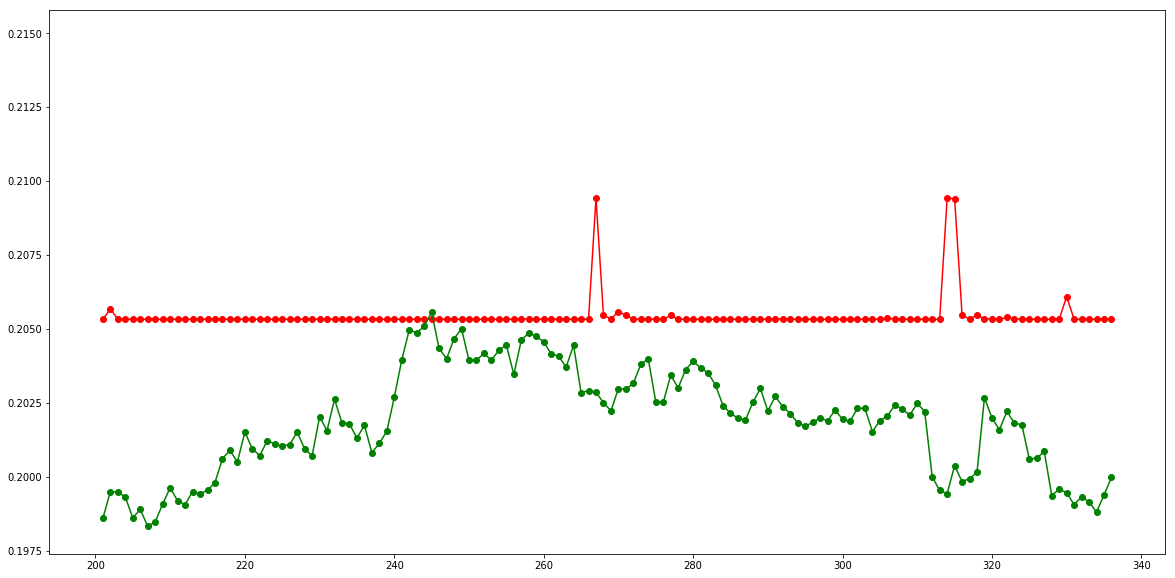

In [35]:
plt.figure(figsize=(20,10))
# visualizer.plot()
# for color in ['blue', 'red']:
for color in ['red']:
    color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
#     plt.scatter([color_df.iloc[0,0]], [color_df.iloc[0, -2]*10], color=color)
#     plt.plot([color_df.iloc[0,0]], [color_df.iloc[0, -2]*10], color=color)
#     plt.scatter([color_df.iloc[0,0]], [color_df.iloc[0, -1]*10], color='g')
#     plt.plot([color_df.iloc[0,0]], [color_df.iloc[0, -1]*10], color='g')
plt.show()

### BS10 maxLR==0.01 3lstms
Epoch: 85/100... Step: 8738... Loss: 0.000911... Val Loss: 0.000262
Validation loss decreased (0.000265 --> 0.000262).  Saving model ...

In [ ]:
plt.figure(figsize=(20,10))
# visualizer.plot()
# for color in ['blue', 'red']:
for color in ['red']:
    color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
plt.show()

### BS10 maxLR==0.01 2lstms

In [ ]:
plt.figure(figsize=(20,10))
# visualizer.plot()
for color in ['blue', 'red']:
# for color in ['red']:
    color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
plt.show()

### BS10 maxLR==0.001 2lstms

In [ ]:
plt.figure(figsize=(20,10))
# visualizer.plot()
for color in ['blue', 'red']:
# for color in ['red']:
    color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
# visualizer.plot()
for color in ['black', 'blue', 'red']:
# for color in ['red']:
    color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
plt.show()

Hyperparameters:

- model:
    - embedding_dim=features*2   ✓
    - hidden_dim=features*16  ✓
- learning rate  
- batch size (window size?)
- DONE - DID IMPROVE criterion = nn.MSELoss()   ✓
    - try a loss which scales through time. ✓
- optimizer = torch.optim.Adam(model.parameters(), lr=lr)
- add polynomial features ✓